# Load

In [13]:
import patchseq_utils.analysis as utils
from patchseq_utils import plotting as plot
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# fix slow autocomplete
%config Completer.use_jedi = False

pd.set_option('use_inf_as_na', True)
pd.options.display.max_columns=300
pd.options.display.max_rows=300
sns.set(style='ticks', context='talk')
from importlib import reload

In [14]:
import patchseq_utils.plot.morphology as pm
import patchseq_utils.plot.sweeps as ps

In [15]:
from patchseq_utils import l1_load
from patchseq_utils import util
from importlib import reload
reload(l1_load)
reload(util)

<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [5]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *

In [31]:
mouse_df = mouse_df.loc[lambda df: df.structure.str.contains('VIS')]
human_all = human_df
human_aibs = human_df.query('collaborator=="AIBS"')
mouse_l1 = mouse_df.loc[ lambda df: df['layer_ccf']=='1']
human_l1 = human_df.loc[ lambda df: df['layer']=='1']
# margin = 20
# mouse_l12 = mouse_df.loc[ lambda df: df['ccf_depth'] < 115 + margin]
# human_l12 = human_df.loc[ lambda df: (df['layer']=='1') | ((df['layer']=='2') & (df['layer_depth'] < margin))]
human_l12 = human_df.loc[ lambda df: (df['layer']=='1') |
                         ((df['layer']=='2') & (df['normalized_layer_depth'] < 0.2))]
mouse_l12 = mouse_df.loc[ lambda df: (df['layer']=='1') |
                         ((df['layer']=='2/3') & (df['normalized_layer_depth'] < 0.2))]
# human_l1 = human_df.loc[ lambda df: (df['soma_layer']==1)]

# TODO: fillna homology for L1 only??
combined_all_l1 = pd.concat([human_aibs.query("layer=='1'"), mouse_l1], sort=False)
combined = combined_all_l1.dropna(subset=['homology_type']).copy()
combined_morph = pd.concat([human_l1, mouse_l1], 
                           sort=False).dropna(subset=['homology_type']).copy()
combined_l12 = pd.concat([human_l12, mouse_l12], 
                           sort=False).dropna(subset=['homology_type']).copy()

# include collab?
# combined_all = pd.concat([human_df, mouse_df], sort=False).dropna(subset=['homology_type']).sample(frac=1, random_state=42)



In [159]:
combined.species.value_counts()

mouse    227
human    189
Name: species, dtype: int64

In [160]:
human_l1.query('has_morph').homology_type.value_counts()

LAMP5     29
PAX6      18
MC4R      10
other      6
L1 VIP     4
Name: homology_type, dtype: int64

In [161]:
human_l12.loc[human_l12.index.difference(human_l1.index)].query('has_morph').homology_type.value_counts()

other     1
MC4R      1
PAX6      1
L1 VIP    0
LAMP5     0
Name: homology_type, dtype: int64

In [162]:
mouse_l1.query('has_morph').homology_type.value_counts()

LAMP5     26
L1 VIP     7
MC4R       6
other      0
PAX6       0
Name: homology_type, dtype: int64

In [163]:
mouse_l12.loc[mouse_l12.index.difference(mouse_l1.index)].query('has_morph').homology_type.value_counts()

LAMP5     4
L1 VIP    1
PAX6      1
other     0
MC4R      0
Name: homology_type, dtype: int64

In [276]:
# TODO: better outlier removal?
combined.loc[lambda df: df['input_resistance'] > 1000, 'input_resistance'] = np.nan

data = combined.loc[combined[ephys_features].notna().sum(axis=1)>0]
morph_remove = [
    'soma_aligned_dist_from_pia',
    'basal_dendrite_frac_above_axon',
               ]
morph_features_compare = [x for x in morph_features if x not in morph_remove and '_pc' not in x]
morph_features_compare

['axon_bias_x',
 'axon_bias_y',
 'axon_emd_with_basal_dendrite',
 'axon_exit_distance',
 'axon_exit_theta',
 'axon_extent_x',
 'axon_extent_y',
 'axon_frac_above_basal_dendrite',
 'axon_frac_below_basal_dendrite',
 'axon_frac_intersect_basal_dendrite',
 'axon_max_branch_order',
 'axon_max_euclidean_distance',
 'axon_max_path_distance',
 'axon_mean_contraction',
 'axon_num_branches',
 'axon_soma_percentile_x',
 'axon_soma_percentile_y',
 'axon_total_length',
 'basal_dendrite_bias_x',
 'basal_dendrite_bias_y',
 'basal_dendrite_calculate_number_of_stems',
 'basal_dendrite_extent_x',
 'basal_dendrite_extent_y',
 'basal_dendrite_frac_below_axon',
 'basal_dendrite_frac_intersect_axon',
 'basal_dendrite_max_branch_order',
 'basal_dendrite_max_euclidean_distance',
 'basal_dendrite_max_path_distance',
 'basal_dendrite_mean_contraction',
 'basal_dendrite_mean_diameter',
 'basal_dendrite_num_branches',
 'basal_dendrite_soma_percentile_x',
 'basal_dendrite_soma_percentile_y',
 'basal_dendrite_stem

In [273]:
complete_features = np.array(ephys_features)[(data[ephys_features].notna().mean(axis=0)>0.80)]

data[ephys_features].notna().mean(axis=0).sort_values()

adp_v_last_rheo                           0.177885
sag_tau_depol                             0.233173
low_freq_impedance_chirp                  0.362981
peak_ratio_chirp                          0.362981
total_inductive_phase_chirp               0.367788
phase_peak_chirp                          0.367788
sync_freq_chirp                           0.367788
peak_impedance_chirp                      0.367788
3db_freq_chirp                            0.367788
peak_freq_chirp                           0.367788
phase_low_chirp                           0.367788
sag_tau                                   0.439904
mean_isi_rheo                             0.627404
first_isi_inv_rheo                        0.627404
sag_depol                                 0.822115
ir_late_hero                              0.826923
sag_area_depol                            0.826923
ir_late_mean                              0.903846
adapt_hero                                0.920673
mean_isi_hero                  

In [136]:
mouse_df.project_code.value_counts(dropna=False)

mIVSCC-MET     579
mIVSCC-METx      4
Name: project_code, dtype: int64

In [137]:
mouse_df.cortical_area_ccf.value_counts(dropna=False)

VISp      482
VISpm      50
VISl       26
VISli       7
VISpor      6
VIS         6
VISal       3
VISa        2
VISpl       1
Name: cortical_area_ccf, dtype: int64

# Proportions

In [25]:
facs_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/Mm_VISp_AIT2.3.0_20047_202005"
facs_df = shiny.load_shiny_data(None, directory=facs_dir, drop_offpipeline=False, nms_pass=False)
facs_df = facs_df[facs_df['class']=="GABAergic"]

genotypes = [
    "Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt",
    "Gad2-IRES-Cre/wt;Ai14(RCL-tdT)/wt",
    "Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt"
]
df = facs_df.loc[lambda df: df['genotype'].isin(genotypes)
                & (df['layer']=="L1")
                ]
mouse_facs = df
mouse_facs['homology_type'] = mouse_facs['cluster'].map(homology_mapping_mouse)

/tmp/ipykernel_18060/2552060771.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mouse_facs['homology_type'] = mouse_facs['cluster'].map(homology_mapping_mouse)


In [100]:
facs_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev"
facs_df = shiny.load_shiny_data(None, directory=facs_dir, drop_offpipeline=False, nms_pass=False)
donors = ['H16.24.010', 'H200.1023', 'H200.1025', 'H200.1030']
facs_df = facs_df.loc[lambda df: 
                      df.external_donor_name.isin(donors)
                & (df['layer']=="L1")]
inh_df = facs_df.loc[facs_df['max.leaf.class']=='GABAergic']
human_facs = inh_df.copy()
human_facs[cluster] = human_facs['cluster'].map(shorten_name).astype(ttypes_human)
human_facs['homology_type'] = human_facs[cluster].map(homology_mapping_human)

Text(0.5, 0, 'L1 fraction')

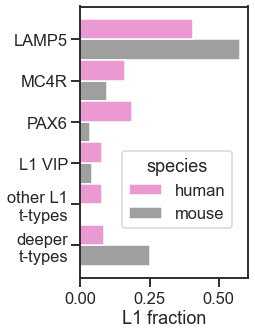

In [53]:
data = pd.concat([human_l1, mouse_facs.assign(species='mouse')], sort=False)
other = 'other L1\nt-types'
deep = 'deeper\nt-types'
data.homology_type = data.homology_type.replace('other', other)
data.homology_type = data.homology_type.fillna(deep)
long_subclasses = CategoricalDtype(categories=['LAMP5', 'MC4R', 'PAX6', 'L1 VIP', other, deep],
                                   ordered=True)
data.homology_type = data.homology_type.astype(long_subclasses)
fig, ax = plt.subplots(figsize=(3,5))
sns.histplot(data=data, y='homology_type', hue='species', palette=species_palette, ax=ax, 
             multiple='dodge', stat='probability', common_norm=False)
l = ax.get_legend().set_bbox_to_anchor([0.2, 0.5])
# sns.displot(data=combined, y='homology_type', hue='species', palette=species_palette, ax=ax)
ax.set_ylabel(None)
ax.set_xlabel('L1 fraction')

In [57]:
utils.fisher_test_all(data, meta='species', cluster='homology_type')

PAX6                 7.129002e-13
other L1\nt-types    8.756729e-12
deeper\nt-types      1.076009e-08
LAMP5                7.040409e-06
MC4R                 1.011982e-02
L1 VIP               2.934803e-02
dtype: float64

/tmp/ipykernel_18060/1113668481.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(l1_types_human, rotation=45, fontstyle='italic', ha='right')


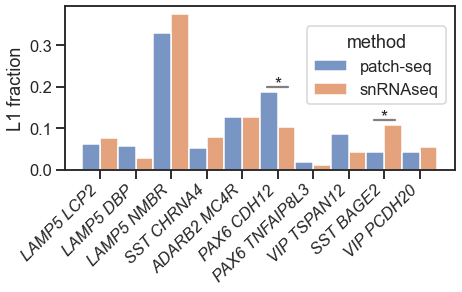

In [114]:
data = pd.concat([human_df.query("l1_type & layer=='1'").assign(method="patch-seq"), 
                  human_facs.loc[lambda df: df[cluster].isin(l1_types_human)].assign(method='snRNAseq')],
                  sort=False)

fig, ax = plt.subplots(figsize=(7,3))
sns.histplot(data=data, x=cluster, hue='method', ax=ax, 
             multiple='dodge', stat='probability', common_norm=False, zorder=0)
l = ax.get_legend().set_bbox_to_anchor([0.6, 0.35])
# sns.displot(data=combined, y='homology_type', hue='species', palette=species_palette, ax=ax)
ax.set_xlabel(None)
ax.set_ylabel('L1 fraction')
ax.set_xticklabels(l1_types_human, rotation=45, fontstyle='italic', ha='right')
dx = np.array([-0.3, 0.3])
utils.plot_sig_bar(pval=0.04, y=0.2, x_pair=5+dx, ax=ax)
utils.plot_sig_bar(pval=0.04, y=0.12, x_pair=8+dx, ax=ax)
plt.show()

In [77]:
utils.fisher_test_all(data, meta='method', cluster=cluster)

PAX6 CDH12        0.001485
SST BAGE2         0.004052
VIP TSPAN12       0.016690
LAMP5 DBP         0.059520
LAMP5 NMBR        0.228815
SST CHRNA4        0.229286
PAX6 TNFAIP8L3    0.504901
LAMP5 LCP2        0.548870
VIP PCDH20        0.601938
ADARB2 MC4R       1.000000
dtype: float64

ValueError: cannot set using a list-like indexer with a different length than the value

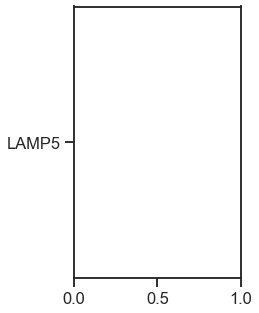

In [58]:
data = pd.concat([human_facs.assign(species='human'), mouse_facs.assign(species='mouse')], sort=True)
other = 'other L1\nt-types'
deep = 'deeper\nt-types'
data.homology_type = data.homology_type.replace('other', other)
data.homology_type = data.homology_type.fillna(deep)
long_subclasses = CategoricalDtype(categories=[ 'LAMP5', 'MC4R', 'PAX6', 'L1 VIP', other, deep],
                                   ordered=True)
data.homology_type = data.homology_type.astype(long_subclasses)
fig, ax = plt.subplots(figsize=(3,5))
sns.histplot(data=data, y='homology_type', hue='species', palette=species_palette, ax=ax, 
             multiple='dodge', stat='probability', common_norm=False)
l = ax.get_legend().set_bbox_to_anchor([0.2, 0.5])
# sns.displot(data=data, y='homology_type', hue='species', palette=species_palette, ax=ax)
ax.set_ylabel(None)
ax.set_xlabel('L1 fraction')

In [59]:
utils.fisher_test_all(data, meta='species', cluster='homology_type')

other L1\nt-types    1.492629e-28
LAMP5                1.567059e-10
PAX6                 5.160512e-06
deeper\nt-types      3.314719e-05
MC4R                 5.272222e-05
L1 VIP               6.709012e-01
dtype: float64

In [62]:
pd.crosstab(data['species'], data['homology_type'], normalize='index')

homology_type     LAMP5      MC4R      PAX6    L1 VIP  other L1\nt-types  \
species                                                                    
human          0.401651  0.173315  0.094911  0.035763           0.134801   
mouse          0.576677  0.097444  0.033546  0.041534           0.000000   

homology_type  deeper\nt-types  
species                         
human                 0.159560  
mouse                 0.250799

Text(0.5, 0, 'L1 fraction')

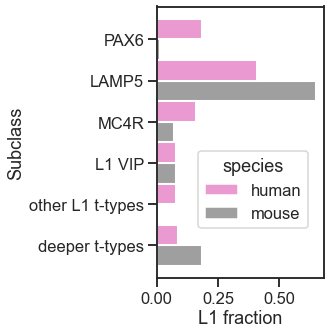

In [138]:
data = pd.concat([human_l1, mouse_l1], sort=False)
data.homology_type = data.homology_type.replace('other', 'other L1 t-types')
data.homology_type = data.homology_type.fillna('deeper t-types')
long_subclasses = CategoricalDtype(categories=['PAX6', 'LAMP5', 'MC4R', 'L1 VIP', 'other L1 t-types', 'deeper t-types'],
                                   ordered=True)
data.homology_type = data.homology_type.astype(long_subclasses)
fig, ax = plt.subplots(figsize=(3,5))
sns.histplot(data=data, y='homology_type', hue='species', palette=species_palette, ax=ax, 
             multiple='dodge', stat='probability', common_norm=False)
l = ax.get_legend().set_bbox_to_anchor([0.2, 0.5])
# sns.displot(data=combined, y='homology_type', hue='species', palette=species_palette, ax=ax)
ax.set_ylabel('Subclass')
ax.set_xlabel('L1 fraction')

Text(0.5, 1.0, 'homology subclasses - all layers')

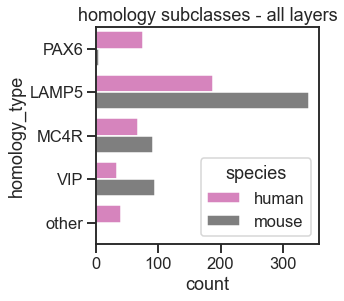

In [49]:
fig, ax = plt.subplots(figsize=(4,4))
data = pd.concat([human_df, mouse_df], sort=False)
sns.countplot(data=data, y='homology_type', hue='species', palette=species_palette, ax=ax, order=homology.keys())
ax.set_title('homology subclasses - all layers')

# Species diff

In [17]:
# combined_all = combined_all[~combined_all.homology_type.str.contains('other')]
# combined = combined[~combined.homology_type.str.contains('other')]

In [139]:
from statsmodels.stats.diagnostic import normal_ad 
def test_normality_worst_case(df, features, group_by=None, test=normal_ad):
    test = lambda x: test(x).pval
    df.groupby(group_by)[features].apply(test).min(axis=0)
    return 

# results = test_normality_worst_case(combined, ephys_features, 'species')

normal_ad(human_df['width_rheo'].dropna())

(2.200565617426605, 1.356752022560967e-05)

In [191]:
results = utils.run_twosamp(combined, complete_features, 'species')

results.head()

pval_mw      mw_r   roc_auc        pval_t  cohens_d  \
feature                                                                      
rheobase_i        9.827159e-61  0.952919  0.976460  5.645108e-81  1.556579   
threshold_i_ramp  1.944208e-59  0.939524  0.969762  1.459797e-70  1.481443   
tau               1.472594e-47  0.842211  0.921106  3.934866e-48  1.294645   
input_resistance  1.267046e-43  0.805707  0.902854  1.130753e-45  1.268787   
sag_area          3.458616e-40  0.715355  0.857677  5.245794e-47  1.281736   

                  nobs    pval_t_fdr   pval_mw_fdr  
feature                                             
rheobase_i         402  4.403184e-79  7.665184e-59  
threshold_i_ramp   403  5.693209e-69  7.582412e-58  
tau                401  7.998861e-47  3.828745e-46  
input_resistance   401  1.259982e-44  2.470740e-42  
sag_area           402  7.743995e-46  5.195017e-39

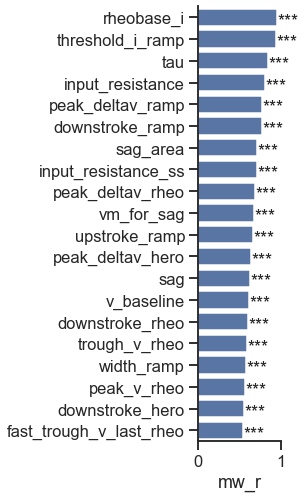

In [192]:
metric='mw_r'
pval='pval_mw_fdr'
utils.plot_feature_effect_sizes(results, pval=pval, val=metric)

In [193]:
corr = combined[complete_features].corr(method='spearman')
labels = {x: feature_name(x) for x in complete_features}
top_feat = utils.select_distinct(results.index, corr, threshold=0.85)

In [194]:
df = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).stack()
df.loc[lambda x: np.abs(x)>0.8]

upstroke_downstroke_ratio_ramp  upstroke_downstroke_ratio_rheo    0.823710
threshold_v_ramp                trough_v_ramp                     0.811838
                                threshold_v_rheo                  0.865206
                                threshold_v_hero                  0.835239
width_ramp                      upstroke_ramp                    -0.846419
                                downstroke_ramp                   0.922117
                                width_suprathresh_ramp            0.974961
                                downstroke_rheo                   0.801436
upstroke_ramp                   downstroke_ramp                  -0.905760
                                width_suprathresh_ramp           -0.820620
                                peak_deltav_ramp                  0.913078
                                upstroke_short_square             0.810883
                                upstroke_rheo                     0.872483
                         

Text(0.5, 0, 'r')

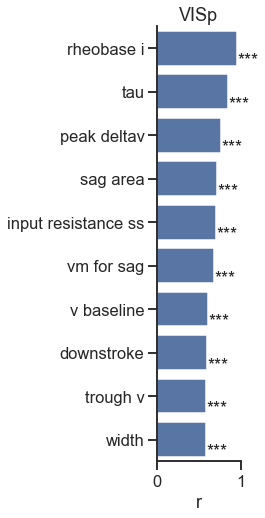

In [195]:
utils.plot_feature_effect_sizes(results.loc[top_feat], ylabels=labels,  pval=pval, val=metric)
plt.title('VISp')
plt.xlim(0, 1)
plt.xlabel('r')

In [29]:
results = utils.run_twosamp(combined_morph, morph_features, 'species')
# utils.plot_feature_effect_sizes(results, pval)
results.head(10)

pval_mw      mw_r   roc_auc  \
feature                                                                
axon_mean_contraction               7.299803e-13  0.838500  0.919250   
soma_aligned_dist_from_pia          5.958625e-11  0.765021  0.882511   
basal_dendrite_num_branches         5.356896e-09  0.681975  0.840987   
axon_frac_above_basal_dendrite      8.122484e-08  0.619977  0.809989   
axon_frac_intersect_basal_dendrite  3.685100e-07  0.594336  0.797168   
basal_dendrite_mean_contraction     1.569946e-06  0.561424  0.780712   
basal_dendrite_max_branch_order     1.166555e-05  0.502105  0.751052   
basal_dendrite_extent_x_over_y      1.109615e-04  0.451971  0.725985   
axon_over_basal_dendrite_extent_x   1.109615e-04  0.451971  0.725985   
basal_dendrite_soma_percentile_x    1.609331e-04  0.441255  0.720628   

                                          pval_t  cohens_d  nobs  \
feature                                                            
axon_mean_contraction               8.255622e-13  1.295485   106   
soma_aligned_dist_from_pia          3.790361e-10  1.164491   106   
basal_dendrite_num_branches         1.208306e-09  1.136226   106   
axon_frac_above_basal_dendrite      3.505282e-07  0.976458   106   
axon_frac_intersect_basal_dendrite  4.919256e-07  0.965537   106   
basal_dendrite_mean_contraction     1.038584e-06  0.940792   106   
basal_dendrite_max_branch_order     1.089129e-05  0.856229   106   
basal_dendrite_extent_x_over_y      1.990879e-02  0.468374   106   
axon_over_basal_dendrite_extent_x   1.446137e-03  0.633646   106   
basal_dendrite_soma_percentile_x    4.823580e-04  0.690988   106   

                                      pval_t_fdr   pval_mw_fdr  
feature                                                         
axon_mean_contraction               4.210367e-11  3.722900e-11  
soma_aligned_dist_from_pia          9.665420e-09  1.519449e-09  
basal_dendrite_num_branches         2.054119e-08  9.106724e-08  
axon_frac_above_basal_dendrite      4.469235e-06  1.035617e-06  
axon_frac_intersect_basal_dendrite  5.017641e-06  3.758802e-06  
basal_dendrite_mean_contraction     8.827968e-06  1.334454e-05  
basal_dendrite_max_branch_order     7.935084e-05  8.499184e-05  
basal_dendrite_extent_x_over_y      5.343939e-02  6.287818e-04  
axon_over_basal_dendrite_extent_x   7.329009e-03  6.287818e-04  
basal_dendrite_soma_percentile_x    3.075032e-03  8.207587e-04

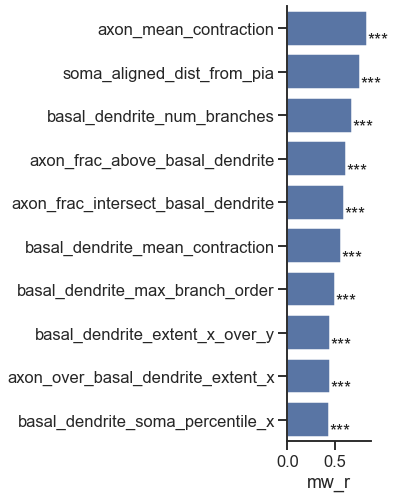

In [31]:
features = morph_features
corr = combined_morph[features].corr(method='spearman')
top_feat = utils.select_distinct(results.index, corr, threshold=0.85)
ylabels = {x: feature_name(x) for x in features}
utils.plot_feature_effect_sizes(results.loc[top_feat], pval=pval, val=metric)

## Morpho

In [32]:
from statsmodels.stats.multitest import multipletests
from statsmodels.tools.sm_exceptions import ValueWarning
import scipy.stats as stats
import warnings
# warning from subtype not represented in mouse
warnings.filterwarnings("ignore", category=ValueWarning)


In [34]:
groups = ['PAX6', 'LAMP5', 'MC4R', 'VIP']
results_e = utils.run_species_subclass_stats(combined, complete_features, groups=groups)
# results_e.to_csv("cross_species_ephys_stats.csv")
results_e.head(10)

eta_p_species  pval_species  pval_species:homology_type  \
feature                                                                     
rheobase_i             0.660765  2.161786e-92                3.712059e-07   
threshold_i_ramp       0.600116  7.791771e-79                7.239863e-08   
sag_area               0.531055  3.442354e-65                6.325985e-08   
tau                    0.529798  6.387702e-65                1.683302e-16   
input_resistance       0.505739  9.247881e-61                5.878442e-04   
sag                    0.457424  5.175459e-53                7.785863e-18   
downstroke_ramp        0.438001  3.406188e-50                2.811199e-02   
peak_deltav_ramp       0.436503  5.043568e-50                1.633754e-03   
peak_deltav_rheo       0.352441  4.882479e-38                5.311171e-05   
upstroke_ramp          0.348200  1.285713e-37                6.734519e-10   

                  rsquared  interaction         sig_groups      PAX6  \
feature                                                                
rheobase_i        0.693452         True  PAX6, LAMP5, MC4R  0.000976   
threshold_i_ramp  0.636849         True  PAX6, LAMP5, MC4R  0.001240   
sag_area          0.642494         True        LAMP5, MC4R  0.351780   
tau               0.633217         True  PAX6, LAMP5, MC4R  0.017486   
input_resistance  0.612552         True  PAX6, LAMP5, MC4R  0.000267   
sag               0.677566         True  PAX6, LAMP5, MC4R  0.038129   
downstroke_ramp   0.482002         True  PAX6, LAMP5, MC4R  0.000079   
peak_deltav_ramp  0.468671         True  PAX6, LAMP5, MC4R  0.007090   
peak_deltav_rheo  0.402308         True        LAMP5, MC4R  0.092488   
upstroke_ramp     0.454674         True  PAX6, LAMP5, MC4R  0.003831   

                         LAMP5          MC4R  
feature                                       
rheobase_i        7.694965e-38  1.584938e-09  
threshold_i_ramp  1.006435e-35  1.861722e-09  
sag_area          9.733850e-38  1.035423e-08  
tau               2.114219e-35  1.492628e-08  
input_resistance  8.735257e-31  6.000266e-09  
sag               5.616135e-25  4.047323e-08  
downstroke_ramp   6.969978e-28  1.454659e-05  
peak_deltav_ramp  8.595134e-26  1.751710e-04  
peak_deltav_rheo  8.025747e-24  3.468495e-03  
upstroke_ramp     1.731980e-26  7.356413e-03

In [35]:
results_m = utils.run_species_subclass_stats(combined_l12, morph_features_compare, groups=groups)
# results_m.to_csv("cross_species_morpho_stats.csv")
results_m

eta_p_species  pval_species  \
feature                                                                 
axon_mean_contraction                          0.432193  3.127524e-12   
soma_aligned_dist_from_pia                     0.414465  7.421335e-12   
basal_dendrite_num_branches                    0.377716  1.084920e-10   
axon_frac_above_basal_dendrite                 0.272454  2.349732e-07   
axon_frac_intersect_basal_dendrite             0.230339  3.388425e-06   
basal_dendrite_mean_contraction                0.225163  3.989673e-06   
basal_dendrite_max_branch_order                0.176326  8.126605e-05   
axon_max_path_distance                         0.149809  3.404117e-04   
basal_dendrite_soma_percentile_x               0.149388  3.404117e-04   
axon_over_basal_dendrite_extent_x              0.127364  1.180556e-03   
basal_dendrite_bias_y                          0.114210  2.378677e-03   
axon_max_euclidean_distance                    0.097022  6.115344e-03   
basal_dendrite_soma_percentile_y               0.093719  6.876275e-03   
axon_extent_x                                  0.087365  9.328369e-03   
axon_total_length                              0.083919  1.069107e-02   
axon_depth_pc_0                                0.070800  2.189719e-02   
basal_dendrite_total_length                    0.068914  2.306084e-02   
axon_emd_with_basal_dendrite                   0.067726  2.337902e-02   
basal_dendrite_max_path_distance               0.066769  2.344939e-02   
basal_dendrite_frac_below_axon                 0.065683  2.376863e-02   
basal_dendrite_extent_x_over_y                 0.050278  5.701275e-02   
axon_over_basal_dendrite_ratio_xy              0.043027  8.448640e-02   
basal_dendrite_extent_y                        0.039502  1.002764e-01   
axon_over_basal_dendrite_extent_y              0.036560  1.152154e-01   
axon_exit_theta                                0.034537  1.253972e-01   
basal_dendrite_frac_intersect_axon             0.031512  1.456855e-01   
axon_extent_y                                  0.030763  1.470618e-01   
basal_dendrite_total_surface_area              0.029415  1.544264e-01   
basal_dendrite_calculate_number_of_stems       0.027772  1.655228e-01   
axon_bias_x                                    0.022904  2.191552e-01   
basal_dendrite_max_euclidean_distance          0.022205  2.220565e-01   
basal_dendrite_mean_diameter                   0.021005  2.328812e-01   
basal_dendrite_extent_x                        0.018794  2.552085e-01   
axon_soma_percentile_y                         0.018413  2.552085e-01   
axon_bias_y                                    0.017961  2.552085e-01   
axon_soma_percentile_x                         0.017892  2.552085e-01   
axon_extent_x_over_y                           0.017457  2.557987e-01   
basal_dendrite_bias_x                          0.016725  2.619241e-01   
basal_dendrite_stem_exit_down                  0.009179  4.421704e-01   
basal_dendrite_stem_exit_side                  0.007679  4.859523e-01   
soma_surface_area                              0.006482  5.238914e-01   
axon_max_branch_order                          0.003249  6.913540e-01   
axon_depth_pc_1                                0.002826  7.065126e-01   
axon_depth_pc_4                                0.002326  7.213762e-01   
axon_num_branches                              0.002242  7.213762e-01   
basal_dendrite_stem_exit_up                    0.001044  8.026999e-01   
axon_frac_below_basal_dendrite                 0.000979  8.026999e-01   
basal_dendrite_frac_above_axon                 0.000911  8.026999e-01   
axon_depth_pc_2                                0.000849  8.026999e-01   
axon_exit_distance                             0.000106  9.364855e-01   
axon_depth_pc_3                                0.000057  9.402141e-01   

                                          pval_species:homology_type  \
feature                                                                
axon_mean_contraction       

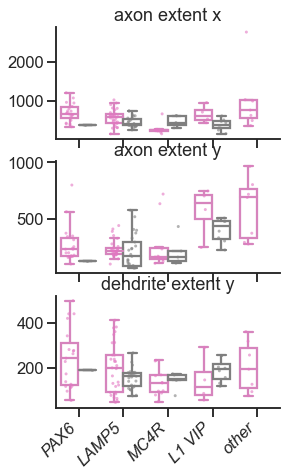

In [343]:
features = [
    'axon_extent_x',
    'axon_extent_y',
    'basal_dendrite_extent_y',
]
labels = feature_name
utils.plot_boxplot_multiple(data=combined_l12, x='homology_type', features=features, labels=labels,
                            plot_function=plot.plot_nested_comparisons, compare='species', 
                            test_subgroups=False,
               palette=species_palette, figsize=(4,7))

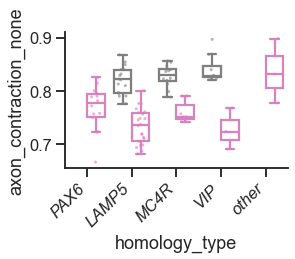

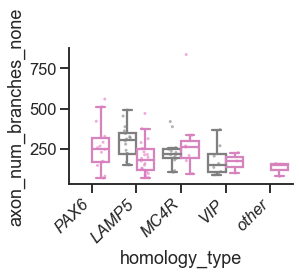

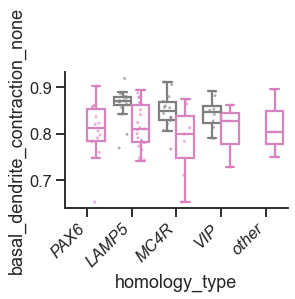

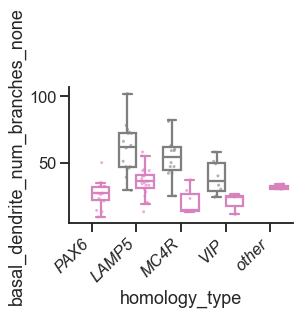

In [37]:
features = [
    'axon_contraction_none',
    'axon_num_branches_none',
    'basal_dendrite_contraction_none',
    'basal_dendrite_num_branches_none',
]
for y in features:
    plot.box_strip(data=combined, x='homology_type', y=y, hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)

KeyError: ''

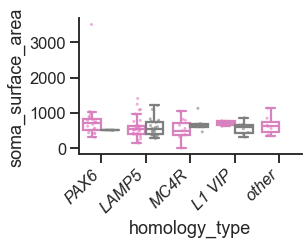

Traceback (most recent call last):
  File "/local1/storage/envs/ipfx3/lib/python3.7/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 267, in _on_run
    self.process_net_command_json(self.py_db, json_contents)
  File "/local1/storage/envs/ipfx3/lib/python3.7/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_process_net_command_json.py", line 192, in process_net_command_json
    cmd = on_request(py_db, request)
  File "/local1/storage/envs/ipfx3/lib/python3.7/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_process_net_command_json.py", line 801, in on_setexceptionbreakpoints_request
    if 'Python Exceptions' in exception_paths[0]['names']:
KeyError: 'names'


In [38]:
y = 'soma_surface_area'
plot.plot_nested_comparisons(data=combined_l12, x='homology_type', y=y, compare='species', 
                   palette=species_palette, test_subgroups=True, fdr_method='fdr_bh')

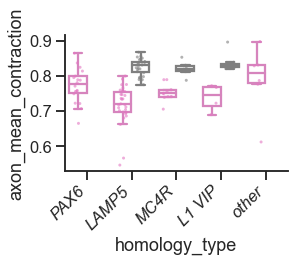

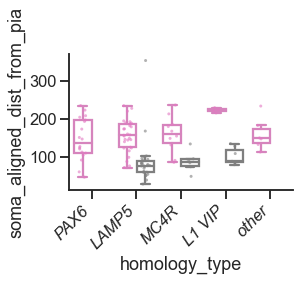

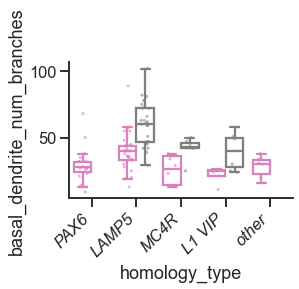

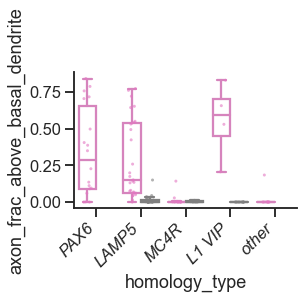

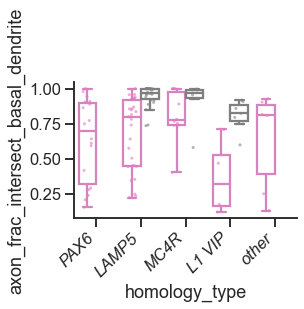

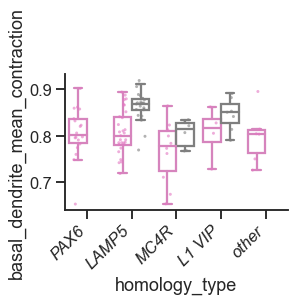

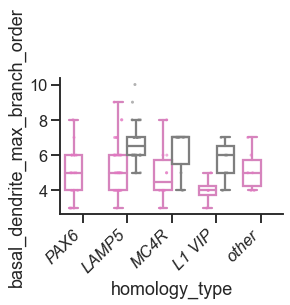

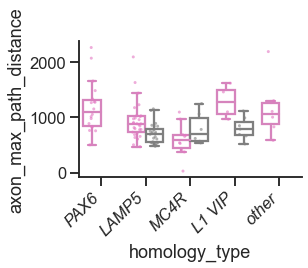

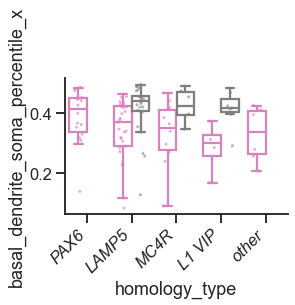

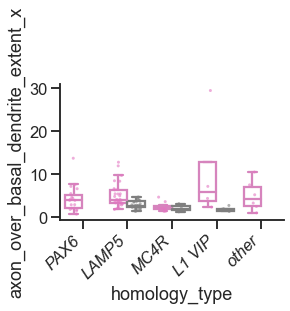

In [39]:
for y in results_m.index[:10]:
    plot.plot_nested_comparisons(data=combined_morph, x='homology_type', y=y, compare='species', 
                   palette=species_palette, test_subgroups=results_m.loc[y, 'interaction'])

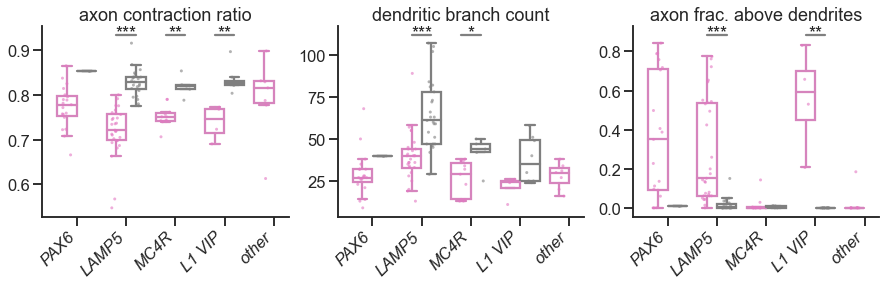

In [ ]:
# TODO: plot significance by subplot
features = [
    'axon_mean_contraction',
    'basal_dendrite_num_branches',
    'axon_frac_above_basal_dendrite',
]
labels = [
    "axon contraction ratio",
     "dendritic branch count",
    'axon frac. above dendrites'
]
utils.plot_boxplot_multiple(data=combined_l12, x='homology_type', features=features, labels=labels,
                            plot_function=plot.plot_nested_comparisons, compare='species', fdr_method='fdr_bh',
               palette=species_palette, horizontal=True, figsize=(15,3.5))

## Ephys

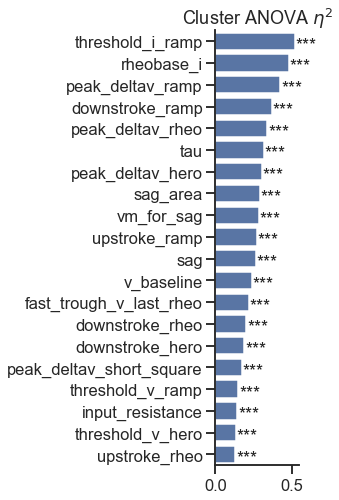

In [30]:
results = utils.run_cluster_anova(combined_all_l1, complete_features, cluster_var='species')

utils.plot_cluster_anova_bar(results, )

In [161]:
reload(plot)

<module 'plotting' from '/allen/programs/celltypes/workgroups/humancolumn_ephysmodeling/tom/projects/ephys_analysis/plotting.py'>

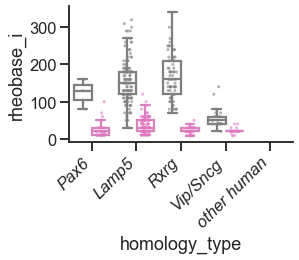

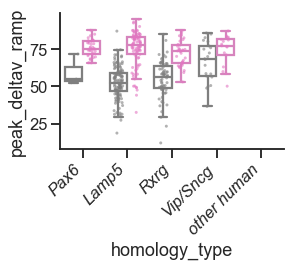

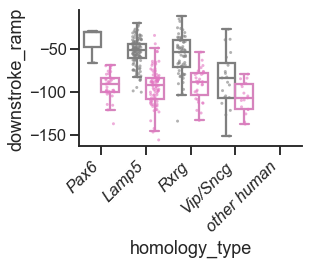

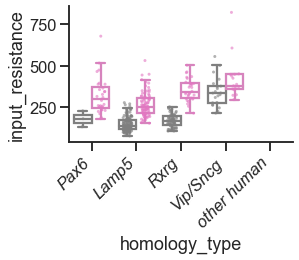

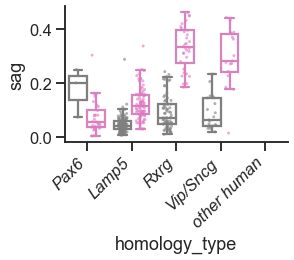

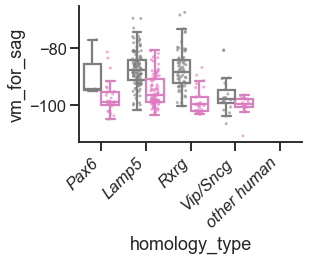

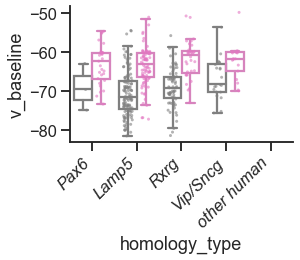

In [19]:
for y in ['rheobase_i', 'peak_deltav_ramp', 'downstroke_ramp', 'input_resistance', 'sag', 'vm_for_sag', 'v_baseline']:
    plot.box_strip(data=combined, x='homology_type', y=y, hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)

In [44]:
def plot_e(y, label):
    plot.plot_nested_comparisons(data=combined, x='homology_type', y=y, compare='species', fdr_method='fdr_bh',
                       palette=species_palette, test_subgroups=results_e.loc[y, 'interaction'])
    plt.title(label)
    plt.ylabel('')
    plt.xlabel("subclass")

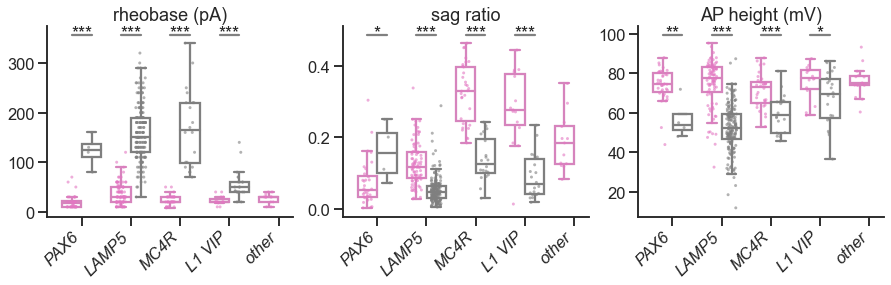

In [117]:
# TODO: plot significance by subplot
features = [
    'rheobase_i',
    'sag',
    'peak_deltav_ramp',
]
labels = [
   "rheobase (pA)",
    "sag ratio",
    "AP height (mV)"
]
utils.plot_boxplot_multiple(data=combined, x='homology_type', features=features, labels=labels,
                            plot_function=plot.plot_nested_comparisons, compare='species', fdr_method='fdr_bh',
               palette=species_palette, horizontal=True, figsize=(15,3.5))

### Sag explanations

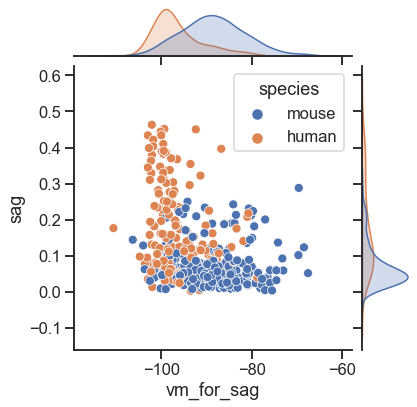

In [27]:
sns.jointplot(x='vm_for_sag',y='sag', data=combined, hue='species')

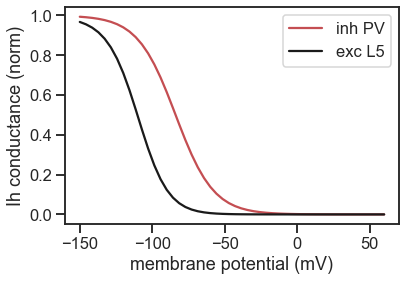

In [74]:
vtrap = lambda x,y: x / (np.exp(x / y) - 1)
mAlpha = lambda v: 0.001 * 6.43 * vtrap(v + 154.9, 11.9)
mBeta  =  lambda v: 0.001*193*np.exp(v/33.1)
ih_amp_exc = lambda v: mAlpha(v)/(mAlpha(v) + mBeta(v))
vm = -83.9
k = 13.1
# A = 1-0.08
A = 1
ih_amp = lambda v: A/(1 + np.exp((v-vm)/k)) + 1-A
v = np.linspace(-150, 60, 50)
plt.plot(v, ih_amp(v), 'r', label='inh PV')
plt.plot(v, ih_amp_exc(v), 'k', label='exc L5')
plt.ylabel('Ih conductance (norm)')
plt.xlabel('membrane potential (mV)')
plt.legend()

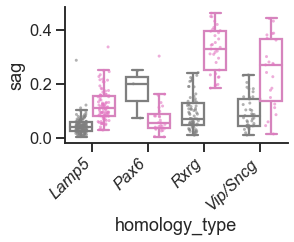

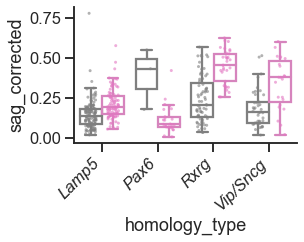

In [75]:
data = combined
fcn = ih_amp
g_base = 1/data.input_resistance
g_sag = g_base / (1-data.sag)
g_sag = g_base + (g_sag - g_base)/(fcn(data.vm_for_sag) - fcn(data.v_baseline))
data['sag_corrected'] = 1 - (g_base/g_sag)
plot.box_strip(data=data, x='homology_type', y='sag', hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)
plot.box_strip(data=data, x='homology_type', y='sag_corrected', hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)
# plt.ylim(0,5)

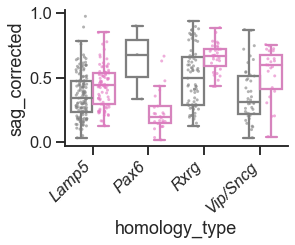

In [69]:
data = combined
fcn = ih_amp_exc
g_base = 1/data.input_resistance
g_sag = g_base / (1-data.sag)
g_sag = g_base + (g_sag - g_base)/(fcn(data.vm_for_sag) - fcn(data.v_baseline))
data['sag_corrected'] = 1 - (g_base/g_sag)
plot.box_strip(data=data, x='homology_type', y='sag_corrected', hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)

### AP props / latency

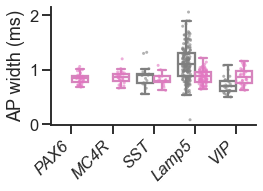

In [186]:
combined['width'] = combined['width_rheo']*1e3
y='width'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False, 
          order=homology.keys(), figsize=(4,3))
plt.ylabel('AP width (ms)')
plt.xlabel(None)
plt.tight_layout()
plt.gcf().savefig(f'/allen/programs/celltypes/workgroups/humancelltypes/tom/figures/boxplot_{y}.svg')

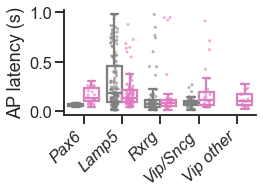

In [79]:
y='latency_rheo'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False, 
          order=homology.keys(), figsize=(4,3))
plt.ylabel('AP latency (s)')
plt.xlabel(None)
plt.tight_layout()
# plt.gcf().savefig(f'/allen/programs/celltypes/workgroups/humancelltypes/tom/figures/boxplot_{y}.svg')

In [347]:
feat = pd.read_csv("~/projects/human_l1/axon_distanceto1st_branch.csv", index_col=0)
feat.head()

path_distances branches_from
spec_id                                
721688585        9.270864      dendrite
832614788        5.274542      dendrite
835572687       24.012182          soma
835648767       18.766987          soma
839950125       57.258284          soma

<AxesSubplot:xlabel='path_distances', ylabel='width_rheo'>

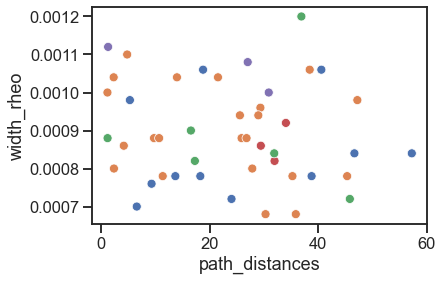

In [356]:
df = combined.join(feat)
sns.scatterplot(data=df, x='path_distances', y='width_rheo', hue='homology_type', legend=False)

### Schumann types?

Krt73/Fam19a1 as alpha7, Tmem182 (and lamb5 subset?) as canopy?

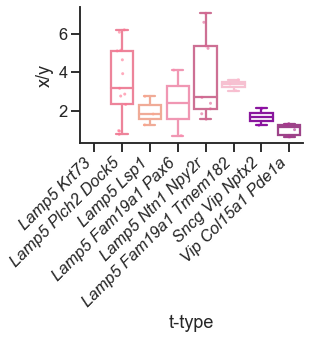

In [23]:
df = mouse_l1.copy()
df['x/y'] = df['axon_extent_x']/df['axon_extent_y']
plot.box_strip(data=df, x=cluster, y='x/y', hue=cluster, palette=palette_mouse, dodge=False)

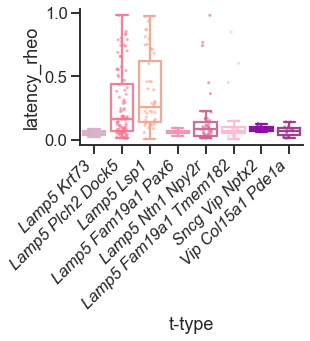

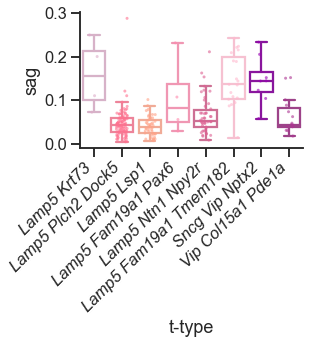

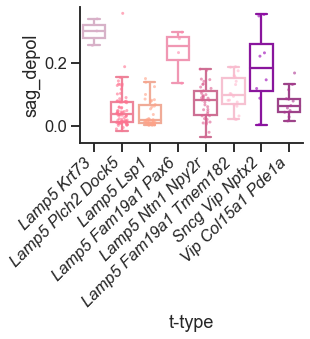

In [19]:
for y in ['latency_rheo', 'sag', 'sag_depol']:
    plot.box_strip(data=mouse_l1, x=cluster, y=y, hue=cluster, palette=palette_mouse, dodge=False)

### Lamp5 feature relationships

AP width clearly related to latency, maybe also linked to Rin difference

(0.0, 0.2)

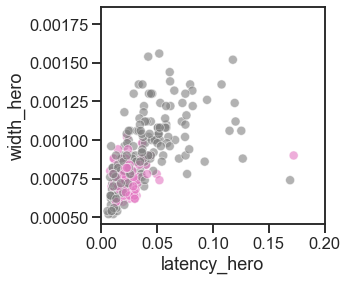

In [252]:
x = 'latency_hero'
y = 'width_hero'
cells = combined[combined.homology_type.str.contains('Lamp5')].sample(frac=1)
plt.figure(figsize=(4,4))
sns.scatterplot(data=cells, x=x, y=y, hue='species', palette=species_palette, legend=False, alpha=0.6)
plt.xlim(0,0.2)

<AxesSubplot:xlabel='input_resistance', ylabel='width_hero'>

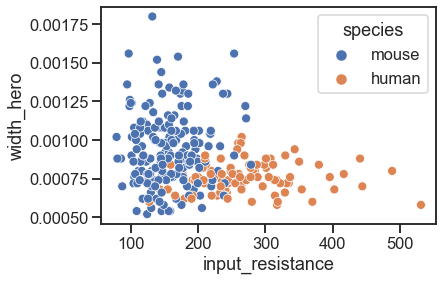

In [356]:
x = 'input_resistance'
y = 'width_hero'
cells = combined[combined.homology_type.str.contains('Lamp5')]
sns.scatterplot(data=cells, x=x, y=y, hue='species')


(0.0, 0.2)

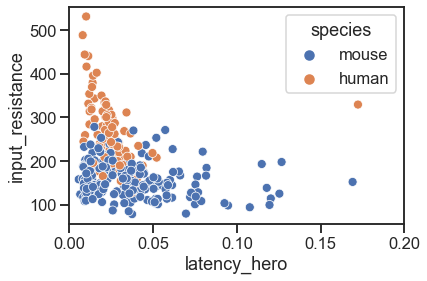

In [358]:
y = 'input_resistance'
x = 'latency_hero'
cells = combined[combined.homology_type.str.contains('Lamp5')]
sns.scatterplot(data=cells, x=x, y=y, hue='species')

plt.xlim(0,0.2)

# canopy?

## Axon / dendrite histograms

In [17]:
group_vals = ['PAX6', 'LAMP5', 'MC4R', 'L1 VIP']
from itertools import combinations
pairs = list(combinations(group_vals, 2))

In [37]:
path = Path("/allen/programs/celltypes/workgroups/mousecelltypes/Matt_Mallory/scripts/Feature_Calculation_Clean/Feature_Data/Mouse_Human_Inhib_L1_Lockdown/Human_Features_7_25_22/AlignedHistogram.csv")
hist_df = pd.read_csv(path, index_col='specimen_id')

In [38]:
dend_df = pd.DataFrame(index=hist_df.index)
comp = 2
n = 250//10
l1_upper_cols = [f"{comp}_{x}" for x in range(0, n)]
dend_df['axon_l1a'] = hist_df[l1_upper_cols].sum(axis=1)

cols = [f"{comp}_{x}" for x in range(n, 2*n)]
dend_df['axon_l1b'] = hist_df[cols].sum(axis=1)
dend_df['axon_all'] = hist_df[[x for x in hist_df.columns if f"{comp}_" in x]].sum(axis=1)
dend_df['L1b_axon_frac'] = dend_df['axon_l1b']/dend_df['axon_all']
dend_df['L1a_axon_frac'] = dend_df['axon_l1a']/dend_df['axon_all']


In [39]:
data = dend_df.join(human_df, how='inner')
data = data.query("layer=='1' | layer=='2'")
data.layer.value_counts()

1    75
2     6
Name: layer, dtype: int64

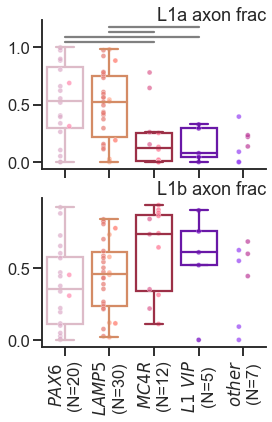

In [40]:
features = ['L1a_axon_frac', 'L1b_axon_frac']
labels = feature_name
utils.plot_boxplot_multiple(
    data, features, labels=labels, x='homology_type', x_fine=cluster, palette_fine=palette_human, palette=palette_subclass,
                                size=5, pairs=pairs, test='dunn', drop_box='other', figsize=(4,6))

In [36]:
fig = plt.gcf()
fig.axes

<Figure size 432x288 with 0 Axes>

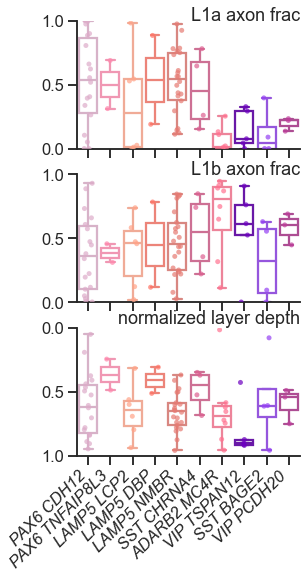

In [43]:
features = ['L1a_axon_frac', 'L1b_axon_frac', 'normalized_layer_depth']
# utils.plot_box_cluster_feature
utils.plot_boxplot_multiple(data=data, x=cluster, labels=labels, features=features, palette=palette_human, 
                            size=5, label_counts=False, figsize=(4,8))

for ax in plt.gcf().axes:
    ax.set_ylim(0,1)
plt.gca().invert_yaxis()

In [44]:
path = Path("/allen/programs/celltypes/workgroups/mousecelltypes/Matt_Mallory/scripts/Feature_Calculation_Clean/Feature_Data/Mouse_Human_Inhib_L1_Lockdown/Mouse_Features_7_25_22/AlignedHistogram.csv")
hist_df = pd.read_csv(path, index_col='specimen_id')

In [45]:
dend_df = pd.DataFrame(index=hist_df.index)
comp = 2
n = 120//10
l1_upper_cols = [f"{comp}_{x}" for x in range(0, n)]
dend_df['axon_l1a'] = hist_df[l1_upper_cols].sum(axis=1)

cols = [f"{comp}_{x}" for x in range(n, 2*n)]
dend_df['axon_l1b'] = hist_df[cols].sum(axis=1)
dend_df['axon_all'] = hist_df[[x for x in hist_df.columns if f"{comp}_" in x]].sum(axis=1)
dend_df['L1b_axon_frac'] = dend_df['axon_l1b']/dend_df['axon_all']
dend_df['L1a_axon_frac'] = dend_df['axon_l1a']/dend_df['axon_all']



In [52]:
data = dend_df.join(mouse_l1, how='inner')
# data = data.query("layer=='1' | layer=='2/3'")
# data = data.query("layer=='1'")
data.layer.value_counts()

1      40
2/3     6
4       1
Name: layer, dtype: int64

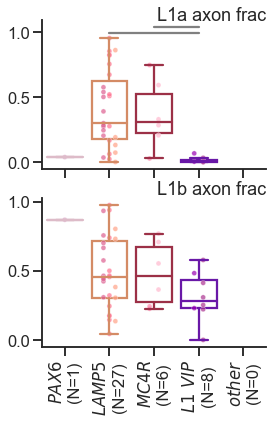

In [34]:
features = ['L1a_axon_frac', 'L1b_axon_frac']
labels = feature_name
palette=palette_mouse
utils.plot_boxplot_multiple(
    data, features, labels=labels, x='homology_type', x_fine=cluster, palette_fine=palette, palette=palette_subclass,
                                  size=5, pairs=pairs, test='dunn', drop_box='other', figsize=(4,6))

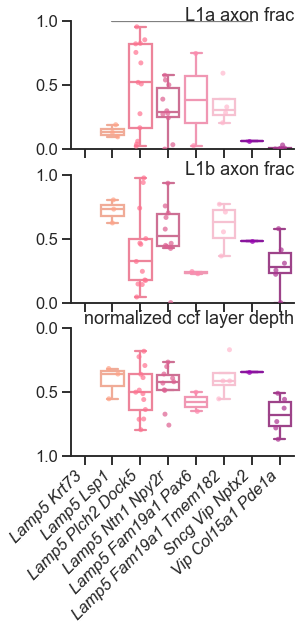

In [53]:
features = ['L1a_axon_frac', 'L1b_axon_frac', 'normalized_ccf_layer_depth']
# utils.plot_box_cluster_feature
data['normalized_ccf_layer_depth'] = data['ccf_depth']/115
# data = data[data[f] < 1]
utils.plot_boxplot_multiple(data=data, x=cluster, labels=labels, features=features, palette=palette, 
                            size=5, label_counts=False, figsize=(4,8))

for ax in plt.gcf().axes:
    ax.set_ylim(0,1)
plt.gca().invert_yaxis()

# within Lamp5 variability 

Text(0, 0.5, 'axon extent x/y')

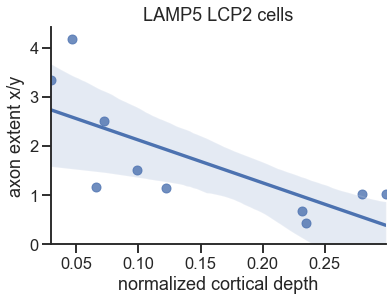

In [365]:
x = 'normalized_depth'
y = 'axon_extent_x_over_y'
data = human_df.loc[lambda df: df[cluster]=="LAMP5 LCP2"]
sns.regplot(data=data, x=x, y=y)
# utils.plot_spearman(data, x, y)
plt.ylim(0,None)
sns.despine()
plt.title("LAMP5 LCP2 cells")
plt.xlabel('normalized cortical depth')
plt.ylabel("axon extent x/y")

Text(0, 0.5, 'axon-dendrite sep. (EM dist.)')

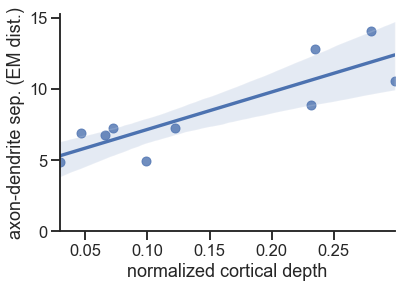

In [372]:
x = 'normalized_depth'
y = 'axon_emd_with_basal_dendrite'
data = human_df.loc[lambda df: df[cluster]=="LAMP5 LCP2"]
sns.regplot(data=data, x=x, y=y)
# utils.plot_spearman(data, x, y)
plt.ylim(0,None)
sns.despine()
# plt.title("LAMP5 LCP2 cells")
plt.xlabel('normalized cortical depth')
plt.ylabel("axon-dendrite sep. (EM dist.)")

Text(0, 0.5, 'axon extent x/y')

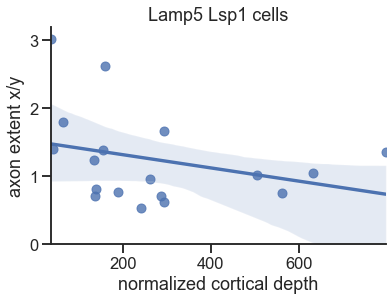

In [366]:
x = 'ccf_depth'
y = 'axon_extent_x_over_y'
data = mouse_df.loc[lambda df: df[cluster]=="Lamp5 Lsp1"]
sns.regplot(data=data, x=x, y=y)
# utils.plot_spearman(data, x, y)
plt.ylim(0,None)
sns.despine()
plt.title("Lamp5 Lsp1 cells")
plt.xlabel('normalized cortical depth')
plt.ylabel("axon extent x/y")

Text(0.5, 0, 'normalized cortical depth')

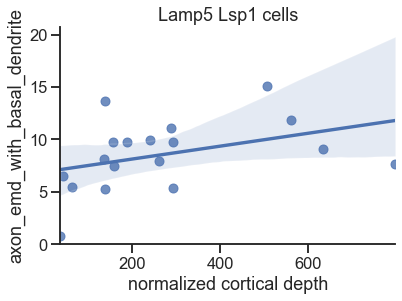

In [371]:
x = 'ccf_depth'
y = 'axon_emd_with_basal_dendrite'
data = mouse_df.loc[lambda df: df[cluster]=="Lamp5 Lsp1"]
sns.regplot(data=data, x=x, y=y)
# utils.plot_spearman(data, x, y)
plt.ylim(0,None)
sns.despine()
plt.title("Lamp5 Lsp1 cells")
plt.xlabel('normalized cortical depth')
# plt.ylabel("axon extent x/y")

# Subclass Markers

In [ ]:
markers_mouse = pd.read_csv("/home/tom.chartrand/projects/human_l1/mouse_markers.csv").drop(columns="Unnamed: 0")
markers_human = pd.read_csv("/home/tom.chartrand/projects/human_l1/human_markers.csv").drop(columns="Unnamed: 0")

markers_mouse.gene = markers_mouse.gene.str.upper()

In [ ]:
markers_mouse.head()

myAUC    avg_diff  power  avg_log2FC  pct.1  pct.2 cluster    gene
0  0.042         NaN  0.916         NaN  0.186  0.982   LAMP5   EGLN3
1  0.045         NaN  0.910         NaN  0.716  1.000   LAMP5   CPLX2
2  0.951         NaN  0.902         NaN  0.986  0.402   LAMP5  MPPED1
3  0.942  289.508888  0.884  462.864544  0.917  0.133   LAMP5    TOX3
4  0.071  -80.091726  0.858 -106.979113  0.371  1.000   LAMP5   NPAS3

In [182]:
results = dict()
for cluster in markers_mouse.cluster.unique():
    human = markers_human.loc[lambda df: df.cluster==cluster].set_index('gene').drop(columns="cluster")
    mouse = markers_mouse.loc[lambda df: df.cluster==cluster].set_index('gene').drop(columns="cluster")
    results[cluster] = (human.join(mouse, rsuffix="_mouse", lsuffix="_human", how='inner')
                        .assign(min_power=lambda df: np.minimum(df.power_human, df.power_mouse))
                        .sort_values('min_power', ascending=False)
                        .loc[:, lambda df: df.columns.insert(0, 'min_power')])

In [403]:
markers_human.loc[lambda df:  (df.cluster=="LAMP5" )& (df.myAUC>0.5)].head(5)

myAUC    avg_diff  power  avg_log2FC  pct.1  pct.2 cluster    gene
0  0.987         NaN  0.974         NaN  0.997  0.930   LAMP5   PTPRT
1  0.982         NaN  0.964         NaN  0.980  0.433   LAMP5    SV2C
3  0.969         NaN  0.938         NaN  0.997  0.599   LAMP5  PTCHD4
4  0.965  392.580917  0.930  566.374541  1.000  0.809   LAMP5   GRIA4
6  0.945  330.687836  0.890  477.081701  1.000  0.854   LAMP5  GRIN2A

In [402]:
markers_mouse.loc[lambda df: (df.cluster=="LAMP5" )& (df.myAUC>0.5)].head(5)

myAUC    avg_diff  power  avg_log2FC  pct.1  pct.2 cluster    gene
2  0.951         NaN  0.902         NaN  0.986  0.402   LAMP5  MPPED1
3  0.942  289.508888  0.884  462.864544  0.917  0.133   LAMP5    TOX3
7  0.917  250.069592  0.834  359.008625  0.856  0.102   LAMP5    SV2C
8  0.915         NaN  0.830         NaN  0.887  0.292   LAMP5   CALN1
9  0.911         NaN  0.822         NaN  0.984  0.785   LAMP5   NYAP2

In [183]:
results["LAMP5"].head()

min_power  myAUC_human  avg_diff_human  power_human  avg_log2FC_human  \
gene                                                                            
NPAS3       0.858        0.057             NaN        0.886               NaN   
SV2C        0.834        0.982             NaN        0.964               NaN   
MPPED1      0.742        0.871             NaN        0.742               NaN   
BRINP2      0.686        0.843             NaN        0.686               NaN   
UNC5C       0.588        0.851             NaN        0.702               NaN   

        pct.1_human  pct.2_human  myAUC_mouse  avg_diff_mouse  power_mouse  \
gene                                                                         
NPAS3         0.960        1.000        0.071      -80.091726        0.858   
SV2C          0.980        0.433        0.917      250.069592        0.834   
MPPED1        0.989        0.577        0.951             NaN        0.902   
BRINP2        0.966        0.569        0.871      343.149138        0.742   
UNC5C         0.983        0.813        0.794      378.968894        0.588   

        avg_log2FC_mouse  pct.1_mouse  pct.2_mouse  min_power  
gene                                                           
NPAS3        -106.979113        0.371        1.000      0.858  
SV2C          359.008625        0.856        0.102      0.834  
MPPED1               NaN        0.986        0.402      0.742  
BRINP2        493.294181        0.918        0.391      0.686  
UNC5C                NaN        0.901        0.619      0.588

In [400]:
markers_human.loc[lambda df: (df.cluster=="PAX6") & (df.myAUC>0.5)].head(5)

myAUC    avg_diff  power  avg_log2FC  pct.1  pct.2 cluster      gene
91   0.979   42.392639  0.958   61.159650  1.000  0.953    PAX6     RALYL
92   0.964  136.938080  0.928  197.559888  0.981  0.293    PAX6    MAN1A1
100  0.905 -127.503193  0.810 -183.948225  1.000  0.974    PAX6     ENOX1
101  0.897  -46.461642  0.794  -67.029980  1.000  0.957    PAX6  KIAA1217
103  0.893  -27.353911  0.786  -39.463351  1.000  1.000    PAX6     NRXN3

In [404]:
markers_mouse.loc[lambda df: (df.cluster=="PAX6") & (df.myAUC>0.5)].head(5)

myAUC    avg_diff  power  avg_log2FC  pct.1  pct.2 cluster     gene
657  0.993         NaN  0.986         NaN  1.000  0.338    PAX6  DPY19L1
658  0.991  391.965937  0.982    7.766623  1.000  0.246    PAX6     PAX6
659  0.980  334.603780  0.960  365.593660  1.000  0.672    PAX6  TSPAN12
660  0.979  331.650362  0.958  293.676404  0.971  0.050    PAX6     ANO3
661  0.966   -3.085574  0.932  -19.323124  0.985  0.119    PAX6   GM2464

In [184]:
results["PAX6"].head()

min_power  myAUC_human  avg_diff_human  power_human  \
gene                                                            
ZMAT4         0.914        0.043     -476.288356        0.914   
KIT           0.740        0.130             NaN        0.740   
PRKCB         0.686        0.062     -219.227908        0.876   
CACNA2D1      0.668        0.085     -604.738083        0.830   
PROX1         0.666        0.167             NaN        0.666   

          avg_log2FC_human  pct.1_human  pct.2_human  myAUC_mouse  \
gene                                                                
ZMAT4          -687.138850        0.615        0.971        0.034   
KIT                    NaN        0.192        0.811        0.041   
PRKCB          -316.279016        0.856        0.998        0.157   
CACNA2D1       -872.452633        0.683        0.951        0.166   
PROX1                  NaN        0.135        0.746        0.081   

          avg_diff_mouse  power_mouse  avg_log2FC_mouse  pct.1_mouse  \
gene                                                                   
ZMAT4                NaN        0.932               NaN        0.456   
KIT                  NaN        0.918               NaN        0.456   
PRKCB                NaN        0.686               NaN        1.000   
CACNA2D1      -466.94299        0.668               NaN        0.853   
PROX1                NaN        0.838               NaN        0.147   

          pct.2_mouse  min_power  
gene                              
ZMAT4           0.997      0.914  
KIT             0.979      0.740  
PRKCB           0.998      0.686  
CACNA2D1        0.971      0.668  
PROX1           0.909      0.666

In [405]:
markers_human.loc[lambda df: (df.cluster=="MC4R") & (df.myAUC>0.5)].head(5)

myAUC    avg_diff  power  avg_log2FC  pct.1  pct.2 cluster     gene
212  0.946         NaN  0.892         NaN  1.000  0.993    MC4R   SORCS1
214  0.924  168.042458  0.848  242.434021  1.000  0.948    MC4R    ASIC2
217  0.910  243.340440  0.820  351.066046  0.981  0.771    MC4R    TSHZ2
218  0.908   78.149069  0.816  112.745275  0.968  0.724    MC4R  FAM19A1
225  0.883   -2.958828  0.766   -4.268687  1.000  0.894    MC4R   HS6ST3

In [408]:
markers_mouse.loc[lambda df: (df.cluster=="MC4R") & (df.myAUC>0.5)].head(20)

myAUC    avg_diff  power  avg_log2FC  pct.1  pct.2 cluster      gene
512  0.922   59.123728  0.844   36.826716  0.979  0.267    MC4R    SORCS1
514  0.920   80.100253  0.840         NaN  1.000  0.642    MC4R    PANTR1
516  0.901   89.580583  0.802   80.801665  0.984  0.402    MC4R   TBC1D8B
517  0.892         NaN  0.784         NaN  0.969  0.221    MC4R     NPAS1
522  0.884   50.331239  0.768   74.538628  1.000  0.437    MC4R     NPAS3
523  0.877  219.246377  0.754  253.115809  0.958  0.359    MC4R     PCDH7
524  0.877         NaN  0.754         NaN  0.995  0.902    MC4R     OLFM2
525  0.872  -12.100150  0.744  -54.127188  0.890  0.216    MC4R  TMEM150C
526  0.860  259.367231  0.720  160.296747  1.000  0.876    MC4R    VSTM2B
529  0.857  -19.278811  0.714  -64.595862  0.990  0.484    MC4R    TEDDM3
530  0.851   23.880241  0.702   36.377904  1.000  0.873    MC4R    SHISA9
531  0.851  121.150011  0.702  100.229087  1.000  1.000    MC4R    ATP1A1
534  0.848  165.786884  0.696  241.105914  0.796  0.144    MC4R   SYNDIG1
538  0.845 -174.894228  0.690 -336.213068  0.974  0.435    MC4R     ASIC4
539  0.844 -117.178746  0.688 -174.599366  1.000  0.993    MC4R       MN1
541  0.843         NaN  0.686         NaN  0.995  0.794    MC4R   GALNTL6
542  0.842  131.867316  0.684   -5.473732  0.916  0.296    MC4R    PCDH18
543  0.842  -73.334723  0.684 -103.873642  0.990  0.811    MC4R     CELF6
544  0.839  171.697318  0.678  116.760276  0.780  0.158    MC4R      CDH4
545  0.837   30.151684  0.674 -344.221306  1.000  0.999    MC4R    TMSB10

In [185]:
results["MC4R"].head()

min_power  myAUC_human  avg_diff_human  power_human  avg_log2FC_human  \
gene                                                                            
SORCS1      0.844        0.946             NaN        0.892               NaN   
NXPH1       0.810        0.095             NaN        0.810               NaN   
TOX2        0.696        0.130             NaN        0.740               NaN   
BRINP2      0.620        0.190             NaN        0.620               NaN   
SV2C        0.618        0.191             NaN        0.618               NaN   

        pct.1_human  pct.2_human  myAUC_mouse  avg_diff_mouse  power_mouse  \
gene                                                                         
SORCS1        1.000        0.993        0.922       59.123728        0.844   
NXPH1         0.465        0.901        0.078             NaN        0.844   
TOX2          0.331        0.825        0.152     -164.676162        0.696   
BRINP2        0.478        0.852        0.166     -420.803556        0.668   
SV2C          0.478        0.794        0.168     -249.353158        0.664   

        avg_log2FC_mouse  pct.1_mouse  pct.2_mouse  min_power  
gene                                                           
SORCS1         36.826716        0.979        0.267      0.844  
NXPH1                NaN        0.168        0.871      0.810  
TOX2         -343.938201        0.178        0.783      0.696  
BRINP2       -605.165204        0.429        0.859      0.620  
SV2C         -357.814565        0.168        0.771      0.618

In [409]:
markers_human.loc[lambda df: (df.cluster=="VIP") & (df.myAUC>0.5)].head(5)

myAUC    avg_diff  power  avg_log2FC  pct.1  pct.2 cluster    gene
316  0.903   82.543050  0.806  119.084449    1.0  0.998     VIP   KCNQ5
319  0.889  -34.408305  0.778  -49.640691    1.0  0.982     VIP  LRRTM4
321  0.887 -162.983457  0.774 -235.135426    1.0  0.954     VIP   ASIC2
322  0.885  -42.634940  0.770  -61.509217    1.0  1.000     VIP   NRXN3
324  0.882         NaN  0.764         NaN    1.0  0.909     VIP   PRKD1

In [410]:
markers_mouse.loc[lambda df: (df.cluster=="VIP") & (df.myAUC>0.5)].head(5)

myAUC    avg_diff  power  avg_log2FC  pct.1  pct.2 cluster    gene
162  0.991         NaN  0.982         NaN  1.000  0.249     VIP   CPNE2
164  0.976         NaN  0.952         NaN  1.000  0.241     VIP   NPAS1
167  0.969         NaN  0.938         NaN  1.000  0.910     VIP    ENHO
169  0.961         NaN  0.922         NaN  0.977  0.337     VIP  THSD7A
174  0.949  209.069941  0.898  135.117652  0.992  0.286     VIP   DDAH1

In [186]:
results["VIP"].head()

min_power  myAUC_human  avg_diff_human  power_human  avg_log2FC_human  \
gene                                                                            
RGS7        0.838        0.081     -213.905028        0.838       -308.599723   
BRINP2      0.780        0.110             NaN        0.780               NaN   
MCTP1       0.714        0.143     -550.271476        0.714       -793.873930   
NPAS3       0.712        0.856             NaN        0.712               NaN   
SORCS1      0.710        0.860             NaN        0.720               NaN   

        pct.1_human  pct.2_human  myAUC_mouse  avg_diff_mouse  power_mouse  \
gene                                                                         
RGS7          1.000        1.000        0.077             NaN        0.846   
BRINP2        0.119        0.826        0.093     -482.476698        0.814   
MCTP1         0.762        0.955        0.104     -377.566169        0.792   
NPAS3         1.000        0.976        0.880       31.808728        0.760   
SORCS1        1.000        0.994        0.855      -21.869700        0.710   

        avg_log2FC_mouse  pct.1_mouse  pct.2_mouse  min_power  
gene                                                           
RGS7                 NaN        0.348        0.954      0.838  
BRINP2       -694.096777        0.121        0.867      0.780  
MCTP1                NaN        0.265        0.901      0.714  
NPAS3         -67.332766        1.000        0.454      0.712  
SORCS1        -29.620854        0.947        0.290      0.710

# Morphology - size diffs

## human vs mouse pyr

In [80]:
path = "/allen/programs/celltypes/workgroups/ivscc/nathang/morph_features/spiny_mouse_me_met_wide_raw.csv"
mouse = pd.read_csv(path, index_col=0)
mouse = mouse.join(lims.get_cells_df(cells_list=mouse.index)).loc[lambda df: df.dendrite_type == "dendrite type - spiny"]
mouse.layer = mouse.structure.map(get_num)

In [87]:
mouse.layer.value_counts(dropna=False)

4      711
5      551
6      392
2/3    177
Name: layer, dtype: int64

In [85]:
path = "/allen/programs/celltypes/workgroups/ivscc/nathang/morph_features/human_spiny_me_and_met_2019-03-27_features_wide_raw.csv"
human = pd.read_csv(path, index_col=0)
human = human.join(lims.get_cells_df(cells_list=human.index)).loc[lambda df: df.dendrite_type == "dendrite type - spiny"]
human.layer = human.layer.fillna('').map(get_num).replace(['1','2','3'], '2/3')

In [87]:
human.layer.value_counts(dropna=False)

4      711
5      551
6      392
2/3    177
Name: layer, dtype: int64

In [88]:
pyrs = pd.concat([mouse.assign(species='mouse'), human.assign(species='human')])

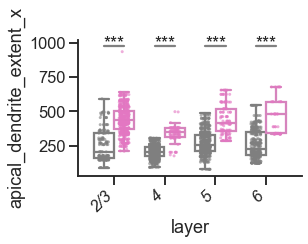

In [89]:
y = 'apical_dendrite_extent_x'
plot.plot_nested_comparisons(data=pyrs, y=y, x='layer', compare='species', palette=species_palette)

In [90]:
pyrs.groupby('layer').apply(lambda df: df.query("species=='human'")[y].mean() / df.query("species=='mouse'")[y].mean())

layer
2/3    1.750692
4      1.617537
5      1.605721
6      1.768398
dtype: float64

In [97]:
y =  'axon_extent_x'
combined_morph.pipe(lambda df: df.query("species=='human'")[y].mean() / df.query("species=='mouse'")[y].mean())

1.3272558952547668

In [99]:
combined_morph.groupby('homology_type').apply(lambda df: df.query("species=='human'")[y].mean() / df.query("species=='mouse'")[y].mean())

homology_type
PAX6           NaN
LAMP5     1.234923
MC4R      0.607229
L1 VIP    1.567660
other          NaN
dtype: float64

## Old work

In [172]:
# morph_human = pd.read_csv(
#     "/allen/programs/celltypes/workgroups/ivscc/nathang/morph_features/human_met_inh_Dec13_features_wide_raw.csv", index_col=0)
# morph_human.columns = [col.replace('_none','') for col in morph_human.columns]
# amorph_human = morph_human.join(human_df, how='inner', rsuffix='_r')

# morph_human = pd.read_csv("../data/L1_All_raw_morphology_features.csv", index_col=1)
# morph_human.columns = [col.replace('_none','') for col in morph_human.columns]
# amorph_human = human_df.join(morph_human, how='inner', rsuffix='_r', on='cell_name')

# morph_human = pd.read_csv("../data/human_aspiny_featuresMay11_2021.csv", index_col=0)
# morph_human = pd.read_excel("../data/L1_aspiny_features_April282021.xlsx", index_col=0)
morph_human = pd.read_excel("../data/human_aspiny_features_withVolumeApril28_2021.xlsx", index_col=1)
morph_human.columns = [col.replace('_none','') for col in morph_human.columns]
# amorph_human = human_df.join(morph_human, how='inner', rsuffix='_r')
# amorph_human = human_df.join(morph_human, how='inner', rsuffix='_r')

morph_mouse = pd.read_csv(
    "/allen/programs/celltypes/workgroups/ivscc/nathang/morph_features/mouse_met_Apr_2020_revisions_features_wide_raw.csv", index_col=0)
morph_mouse.columns = [col.replace('_area','') for col in morph_mouse.columns]
# amorph_mouse = morph_mouse.join(mouse_l1, how='inner')
# amorph_mouse = mouse_df_morph.join(morph_mouse, how='inner')

morph_df = pd.concat([morph_human, morph_mouse], sort=False)
morph_all = combined_all.join(morph_df, lsuffix='_')
morph_l1 = combined.join(morph_df, lsuffix='_')

In [200]:
# mostly deeper t-types missing
shiny_human.loc[morph_human.index.difference(morph_all.index)]

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


exp_component_name layer    batch               cell_name  \
596907611   BT170919-01_E1-50_S48          BT041     H17.03.009.11.08.06   
650077366     SM-GE65Y_S127_E1-50     2  RSC-135     H17.26.003.11.16.04   
665718254     SM-GE91Q_S012_E1-50     3  RSC-146     H18.03.003.11.02.03   
685766680     SM-GE937_S181_E1-50     2  RSC-155     H18.03.008.11.12.01   
685780246     SM-GE937_S184_E1-50     2  RSC-155     H18.03.008.11.12.04   
700801541     SM-GE8X7_S153_E1-50     3  RSC-159  H18.03.012.11.11.01.02   
732115399     SM-GE8YK_S007_E1-50     3  RSC-172  H18.03.314.11.09.01.06   
732127116     SM-GE8YK_S008_E1-50     3  RSC-172  H18.03.314.11.09.01.07   
732141075     SM-GE8YI_S086_E1-50     3  RSC-172  H18.03.314.11.05.01.08   
737159000     SM-GE8YB_S068_E1-50     3  RSC-173  H18.03.315.11.12.01.03   
992386355     SM-J39ZH_S020_E1-50     1  RSC-240     H19.28.018.11.06.04   
1004840721                    NaN   NaN      NaN                     NaN   
1009830462    SM-J2NTQ_S014_E1-50   NaN  RSC-255     H20.28.006.11.08.01   

               spec_id       donor collaborator gender  \
596907611    596907611  H17.03.009          NaN      M   
650077366    650077366  H17.26.003          NaN          
665718254    665718254  H18.03.003          NaN          
685766680    685766680  H18.03.008          NaN      F   
685780246    685780246  H18.03.008          NaN      F   
700801541    700801541  H18.03.012          NaN          
732115399    732115399  H18.03.314          NaN    NaN   
732127116    732127116  H18.03.314          NaN    NaN   
732141075    732141075  H18.03.314          NaN    NaN   
737159000    737159000  H18.03.315          NaN    NaN   
992386355    992386355  H19.28.018        Gabor          
1004840721         NaN         NaN          NaN    NaN   
1009830462  1009830462  H20.28.006        Gabor          

                          collection medical_conditions        postPatch  \
596907611   Patch-seq Pre-production           Epilepsy          No-Seal   
650077366       Patch-seq Production              Tumor  nucleus_present   
665718254       Patch-seq Production           Epilepsy      entire_cell   
685766680       Patch-seq Production           Epilepsy  nucleus_present   
685780246       Patch-seq Production           Epilepsy  nucleus_present   
700801541       Patch-seq Production           Epilepsy  nucleus_present   
732115399       Patch-seq Production           Epilepsy  nucleus_present   
732127116       Patch-seq Production           Epilepsy  nucleus_present   
732141075       Patch-seq Production           Epilepsy  nucleus_present   
737159000       Patch-seq Production           Epilepsy  nucleus_present   
992386355       Patch-seq Production                NaN  nucleus_present   
1004840721                       NaN                NaN              NaN   
1009830462      Patch-seq Production                                 NaN   

           postPatch_classification    filldate rigOperator rigNumber  \
596907611                   No-Seal                                     
650077366           Partial-Nucleus  10/26/2017    lindsayn         7   
665718254               Entire-Cell   1/26/2018    kristenh         2   
685766680                 Nucleated   2/13/2018    lindsayn         1   
685780246                 Nucleated   2/13/2018    lindsayn         1   
700801541                 Nucleated   4/26/2018    lindsayn         2   
732115399                 Nucleated   7/10/2018    lindsayn         7   
732127116                 Nucleated   7/10/2018    lindsayn         7   
732141075                 Nucleated   7/25/2018      rustym         2   
737159000                 Nucleated   7/25/2018    lindsayn         7   
992386355                       NaN                                     
1004840721                      NaN         NaN         NaN       NaN   
1009830462                      NaN         NaN         NaN       NaN   

            cell_depth sliceHealth    patchseq_ro

In [722]:
df = pd.read_csv("/allen/programs/celltypes/workgroups/ivscc/nathang/morph_features/mouse_met_Apr_2020_revisions_features_wide_raw.csv", index_col=0)
list(df)
df.shape

(520, 46)

In [513]:
list(pd.read_csv(
    "/allen/programs/celltypes/workgroups/ivscc/nathang/morph_features/human_met_inh_Dec13_features_wide_raw.csv", index_col=0))

['axon_bias_x',
 'axon_bias_y',
 'axon_contraction_none',
 'axon_emd_with_basal_dendrite_none',
 'axon_extent_x',
 'axon_extent_y',
 'axon_hist_pc_0_none',
 'axon_hist_pc_1_none',
 'axon_hist_pc_2_none',
 'axon_hist_pc_3_none',
 'axon_hist_pc_4_none',
 'axon_hist_pc_5_none',
 'axon_max_branch_order_none',
 'axon_max_euclidean_distance_none',
 'axon_max_path_distance_none',
 'axon_num_branches_none',
 'axon_pct_above_basal_dendrite_none',
 'axon_pct_below_basal_dendrite_none',
 'axon_pct_intersect_basal_dendrite_none',
 'axon_soma_distance_none',
 'axon_soma_percentile_x',
 'axon_soma_percentile_y',
 'axon_soma_theta_none',
 'axon_total_length_none',
 'basal_dendrite_bias_x',
 'basal_dendrite_bias_y',
 'basal_dendrite_contraction_none',
 'basal_dendrite_extent_x',
 'basal_dendrite_extent_y',
 'basal_dendrite_max_branch_order_none',
 'basal_dendrite_max_euclidean_distance_none',
 'basal_dendrite_max_path_distance_none',
 'basal_dendrite_num_branches_none',
 'basal_dendrite_num_stems_none

In [518]:
list(pd.read_csv(
    "../data/L1_All_raw_morphology_features.csv", index_col=0))

['cell_name',
 'Tree_first_cl',
 'axon_bias_x',
 'axon_bias_y',
 'axon_contraction_none',
 'axon_emd_with_basal_dendrite_none',
 'axon_extent_x',
 'axon_extent_y',
 'axon_hist_pc_0_none',
 'axon_hist_pc_1_none',
 'axon_hist_pc_2_none',
 'axon_hist_pc_3_none',
 'axon_hist_pc_4_none',
 'axon_max_branch_order_none',
 'axon_max_euclidean_distance_none',
 'axon_max_path_distance_none',
 'axon_num_branches_none',
 'axon_pct_above_basal_dendrite_none',
 'axon_pct_below_basal_dendrite_none',
 'axon_pct_intersect_basal_dendrite_none',
 'axon_soma_distance_none',
 'axon_soma_percentile_x',
 'axon_soma_percentile_y',
 'axon_soma_theta_none',
 'axon_total_length_none',
 'basal_dendrite_average_diameter_none',
 'basal_dendrite_bias_x',
 'basal_dendrite_bias_y',
 'basal_dendrite_contraction_none',
 'basal_dendrite_extent_x',
 'basal_dendrite_extent_y',
 'basal_dendrite_hist_pc_0_none',
 'basal_dendrite_hist_pc_1_none',
 'basal_dendrite_hist_pc_2_none',
 'basal_dendrite_hist_pc_3_none',
 'basal_dendr

In [194]:
import plotting as plot
reload(plot)

<module 'plotting' from '/allen/programs/celltypes/workgroups/humancolumn_ephysmodeling/tom/projects/ephys_analysis/plotting.py'>

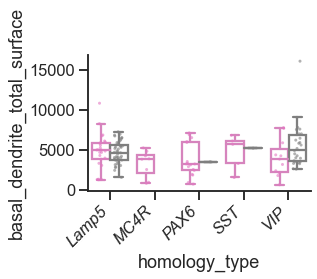

In [203]:
data = morph_all
plot.box_strip(data=data, x='homology_type', y='basal_dendrite_total_surface', hue='species', palette=species_palette, dodge=True)

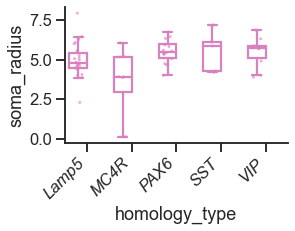

In [176]:
data = morph_l1
plot.box_strip(data=data, x='homology_type', y='soma_radius', hue='species', palette=species_palette, dodge=True)
# plt.ylabel('dend. surf. area')

Text(0, 0.5, 'dend. surf. area')

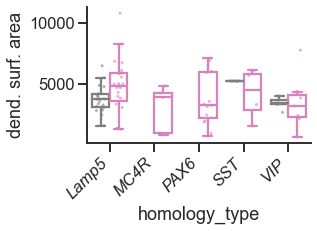

In [222]:
data = morph_l1
plot.box_strip(data=data, x='homology_type', y='basal_dendrite_total_surface', hue='species', palette=species_palette, dodge=True)
plt.ylabel('dend. surf. area')

Text(0, 0.5, 'dend. max dist.')

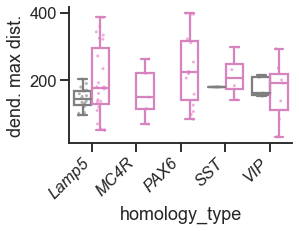

In [223]:
plot.box_strip(data=data, x='homology_type', y='basal_dendrite_max_euclidean_distance', hue='species', palette=species_palette, dodge=True)
plt.ylabel('dend. max dist.')

Text(0, 0.5, 'dend. total length')

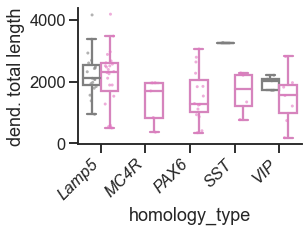

In [224]:
plot.box_strip(data=data, x='homology_type', y='basal_dendrite_total_length', hue='species', palette=species_palette, dodge=True)
plt.ylabel('dend. total length')

Text(0, 0.5, 'dend. # branches')

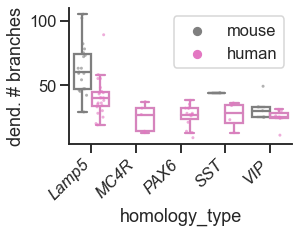

In [225]:
plot.box_strip(data=data, x='homology_type', y='basal_dendrite_num_branches', hue='species', palette=species_palette, dodge=True, legend=True)
plt.ylabel('dend. # branches')

Text(0, 0.5, 'dend. mean radius')

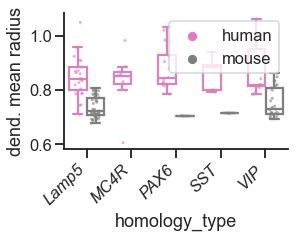

In [209]:
morph_all['mean_radius'] = np.sqrt(morph_all['basal_dendrite_total_surface']/morph_all['basal_dendrite_total_length']/np.pi)
plot.box_strip(data=data, x='homology_type', y='mean_radius', hue='species', palette=species_palette, dodge=True, legend=True)
plt.ylabel('dend. mean radius')

# Cross-type differences comparison

# Combined ANOVA

In [279]:
features = complete_features
ylabels = {x:feature_name(x) for x in features}
group_list = ['human','mouse']
data = combined.query("core_l1_type & failed_fx_long_squares==False")
corr_filter = data[features].corr()

Text(0.5, 0, '$\\epsilon^2$')

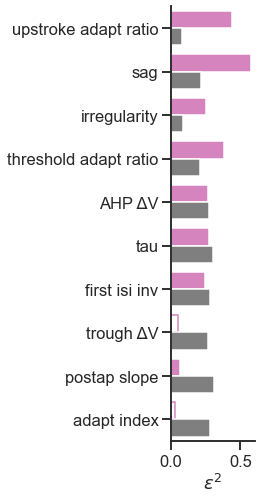

In [280]:
cluster_var = "homology_type"
effect='epsilon2'
results_list = [utils.run_kw_dunn(
    data.query(f"species=='{x}'"), features, cluster_var, posthoc=False)
                for x in group_list]

res = utils.compile_feature_effects_comparison(
    results_list, group_list, effect=effect, pval='pval_cluster', rank='max',
    corr_filter=corr_filter, corr_thresh=0.75, nfeat=10)

utils.plot_feature_effects_comparison_barplot(
    res, pval='pval_cluster', val=effect, 
    ylabels=ylabels, palette=species_palette)
plt.xlabel('$\epsilon^2$')

In [281]:
res

KW_H  pval_cluster  rsquared  epsilon2  \
                             human         human     human     human   
feature                                                                
upstroke_adapt_ratio     70.476692  1.315965e-13  0.427068  0.437743   
sag                      93.654869  2.802002e-18  0.566593  0.574570   
ir_late_mean             40.168441  8.138173e-08  0.239796  0.254231   
threshold_v_adapt_ratio  60.972332  7.104324e-12  0.366913  0.378710   
fast_trough_deltav_hero  42.904547  3.352132e-08  0.249403  0.263218   
tau                      44.944829  1.482921e-08  0.262155  0.275735   
first_isi_inv_hero       40.043047  8.138173e-08  0.232975  0.247179   
trough_slowdeltav_hero    8.215307  6.146598e-02  0.032596  0.050401   
postap_slope_hero        10.682733  2.461752e-02  0.048017  0.065538   
adapt_mean                4.170200  2.754445e-01  0.007314  0.025584   

                              KW_H  pval_cluster  rsquared  epsilon2  \
                             mouse         mouse     mouse     mouse   
feature                                                                
upstroke_adapt_ratio     16.877409  1.062187e-03  0.064546  0.077419   
sag                      48.586238  8.901710e-10  0.206273  0.216903   
ir_late_mean             17.346978  8.824363e-04  0.071025  0.084619   
threshold_v_adapt_ratio  45.871986  2.616595e-09  0.199405  0.210422   
fast_trough_deltav_hero  61.379531  3.850711e-12  0.264161  0.274016   
tau                      67.180855  4.453741e-13  0.291731  0.301259   
first_isi_inv_hero       60.808320  3.850711e-12  0.272681  0.282829   
trough_slowdeltav_hero   60.304771  3.950258e-12  0.259298  0.269218   
postap_slope_hero        69.530139  2.098602e-13  0.301041  0.310402   
adapt_mean               62.781183  2.916676e-12  0.274226  0.284078   

                              max      diff  
                                             
feature                                      
upstroke_adapt_ratio     0.437743  0.360324  
sag                      0.574570  0.357667  
ir_late_mean             0.254231  0.169611  
threshold_v_adapt_ratio  0.378710  0.168288  
fast_trough_deltav_hero  0.274016 -0.010798  
tau                      0.301259 -0.025524  
first_isi_inv_hero       0.282829 -0.035650  
trough_slowdeltav_hero   0.269218 -0.218817  
postap_slope_hero        0.310402 -0.244864  
adapt_mean               0.284078 -0.258494

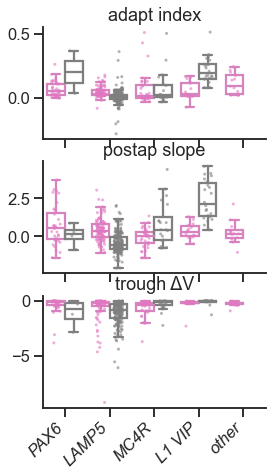

In [284]:
features = [
    'adapt_mean',
    'postap_slope_hero',
    'trough_slowdeltav_hero',
]
labels = feature_name
utils.plot_boxplot_multiple(data=combined, x='homology_type', features=features, labels=labels,
                            plot_function=plot.plot_nested_comparisons, compare='species', 
                            test_subgroups=False,
               palette=species_palette, figsize=(4,7))

Text(0.5, 0, '$\\epsilon^2$')

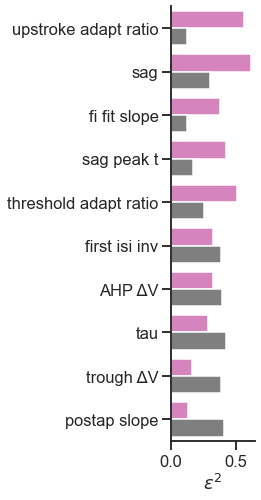

In [50]:
cluster_var = "t-type"
effect='epsilon2'
results_list = [utils.run_kw_dunn(
    data.query(f"species=='{x}'"), features, cluster_var, posthoc=False)
                for x in group_list]

res = utils.compile_feature_effects_comparison(
    results_list, group_list, effect=effect, pval='pval_cluster', rank='max',
    corr_filter=corr_filter, corr_thresh=0.75, nfeat=10)

utils.plot_feature_effects_comparison_barplot(
    res, pval='pval_cluster', val=effect, 
    ylabels=ylabels, palette=species_palette)
plt.xlabel('$\epsilon^2$')

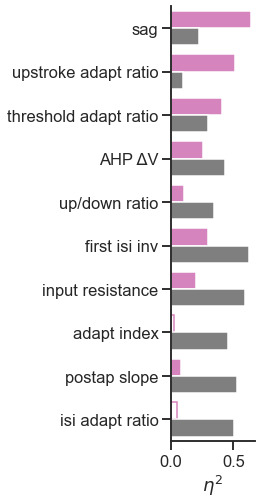

In [ ]:
cluster_var = "homology_type"
results_list = [utils.run_cluster_anova(data.query(f"species=='{x}'"), features,
                                       cluster_var=cluster_var)
                for x in group_list]

res = utils.compile_feature_effects_comparison(
    results_list, group_list, effect='rsquared', pval='pval_cluster', rank='max',
    corr_filter=corr_filter, corr_thresh=0.75)

utils.plot_feature_effects_comparison_barplot(
    res, pval='pval_cluster', val='rsquared', 
    ylabels=ylabels, palette=species_palette)

upstroke_adapt_ratio


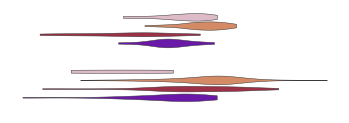

sag


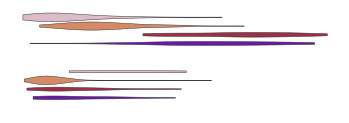

tau


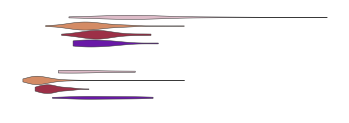

first_isi_inv_hero


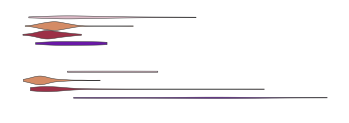

postap_slope_hero


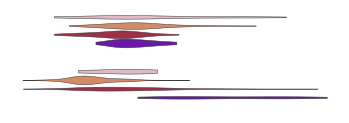

In [209]:
feats = ['upstroke_adapt_ratio', 
         'sag', 
         'tau',
         'first_isi_inv_hero',
        'postap_slope_hero']
for feat in feats:
    print(feat)
    fig, ax = plt.subplots(figsize=(6,2))
    sns.violinplot(data=combined.query("homology_type!='other'"), x=feat, y='species', hue='homology_type', 
                   cut=0, legend=False, palette=palette_subclass, scale='area', scale_hue=True,
                  inner=None, linewidth=0.5, dodge=True, ax=ax,)
    plt.legend().remove()
    ax.axis('off')
    plt.show()

## Morph

In [285]:
features = morph_features_compare
ylabels = {x:feature_name(x) for x in features}
group_list = ['human','mouse']
data = combined_l12.query("core_l1_type")
corr_filter = data[features].corr()

Text(0.5, 0, '$\\epsilon^2$')

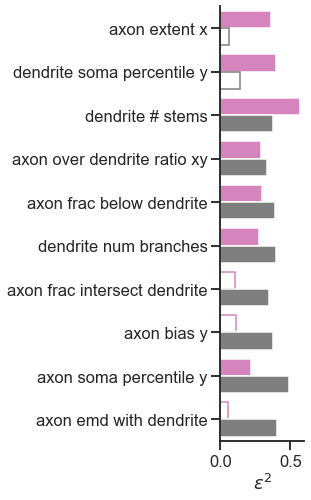

In [286]:
cluster_var = "homology_type"
effect='epsilon2'
results_list = [utils.run_kw_dunn(
    data.query(f"species=='{x}'"), features, cluster_var, posthoc=False)
                for x in group_list]

res = utils.compile_feature_effects_comparison(
    results_list, group_list, effect=effect, pval='pval_cluster', rank='max',
    corr_filter=corr_filter, corr_thresh=0.75, nfeat=10)

utils.plot_feature_effects_comparison_barplot(
    res, pval='pval_cluster', val=effect, 
    ylabels=ylabels, palette=species_palette)
plt.xlabel('$\epsilon^2$')

In [287]:
res

KW_H pval_cluster  rsquared  \
                                              human        human     human   
feature                                                                      
axon_extent_x                             22.275079     0.000839  0.326696   
basal_dendrite_soma_percentile_y          24.574233     0.000417  0.365665   
basal_dendrite_calculate_number_of_stems  35.301750     0.000005  0.547487   
axon_over_basal_dendrite_ratio_xy         17.846033     0.003470  0.251628   
axon_frac_below_basal_dendrite            18.467792     0.003099  0.262166   
basal_dendrite_num_branches               17.326787     0.003805  0.242827   
axon_frac_intersect_basal_dendrite         6.677829     0.127618  0.062336   
axon_bias_y                                6.793903     0.127618  0.064303   
axon_soma_percentile_y                    13.404582     0.013840  0.176349   
axon_emd_with_basal_dendrite               3.523525     0.358458  0.008873   

                                          epsilon2       KW_H pval_cluster  \
                                             human      mouse        mouse   
feature                                                                      
axon_extent_x                             0.359275   2.388462     0.623274   
basal_dendrite_soma_percentile_y          0.396359   5.435077     0.250930   
basal_dendrite_calculate_number_of_stems  0.569383  14.241060     0.019595   
axon_over_basal_dendrite_ratio_xy         0.287839  12.594500     0.030608   
axon_frac_below_basal_dendrite            0.297868  14.917354     0.019595   
basal_dendrite_num_branches               0.279464  15.196917     0.019595   
axon_frac_intersect_basal_dendrite        0.107707  13.164253     0.026994   
axon_bias_y                               0.109579  14.178462     0.019595   
axon_soma_percentile_y                    0.216203  18.518923     0.015124   
axon_emd_with_basal_dendrite              0.056831  15.303385     0.019595   

                                          rsquared  epsilon2       max  \
                                             mouse     mouse             
feature                                                                  
axon_extent_x                            -0.017473  0.062854  0.359275   
basal_dendrite_soma_percentile_y          0.069574  0.143028  0.396359   
basal_dendrite_calculate_number_of_stems  0.321173  0.374765  0.569383   
axon_over_basal_dendrite_ratio_xy         0.274129  0.331434  0.331434   
axon_frac_below_basal_dendrite            0.340496  0.392562  0.392562   
basal_dendrite_num_branches               0.348483  0.399919  0.399919   
axon_frac_intersect_basal_dendrite        0.290407  0.346428  0.346428   
axon_bias_y                               0.319385  0.373117  0.373117   
axon_soma_percentile_y                    0.443398  0.487340  0.487340   
axon_emd_with_basal_dendrite              0.351525  0.402721  0.402721   

                                              diff  
                                                    
feature                                             
axon_extent_x                             0.296421  
basal_dendrite_soma_percentile_y          0.253330  
basal_dendrite_calculate_number_of_stems  0.194618  
axon_over_basal_dendrite_ratio_xy        -0.043595  
axon_frac_below_basal_dendrite           -0.094694  
basal_dendrite_num_branches              -0.120455  
axon_frac_intersect_basal_dendrite       -0.238721  
axon_bias_y                              -0.263538  
axon_soma_percentile_y                   -0.271137  
axon_emd_with_basal_dendrite             -0.345890

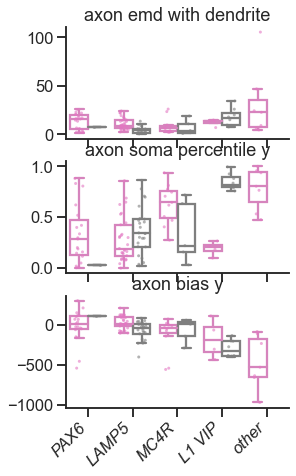

In [290]:
features = [
    'axon_emd_with_basal_dendrite',
    'axon_soma_percentile_y',
    'axon_bias_y',
]
labels = feature_name
utils.plot_boxplot_multiple(data=combined_l12, x='homology_type', features=features, labels=labels,
                            plot_function=plot.plot_nested_comparisons, compare='species', 
                            test_subgroups=False,
               palette=species_palette, figsize=(4,7))

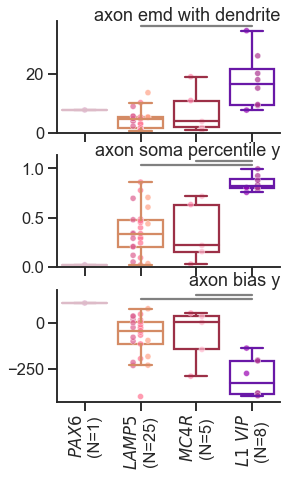

In [342]:
features = [
    'axon_emd_with_basal_dendrite',
    'axon_soma_percentile_y',
    'axon_bias_y',
]
labels = feature_name
utils.plot_boxplot_multiple(mouse_l12, features, 'homology_type', labels=feature_name, 
                            x_fine=cluster, palette_fine=palette_mouse, palette=palette_subclass,
                                   pairs_sets=[pairs], size=6, figsize=(4,7)) 

Text(0.5, 0, '$\\epsilon^2$')

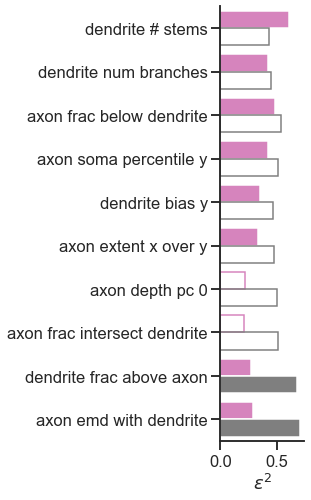

In [244]:
cluster_var = "t-type"
effect='epsilon2'
results_list = [utils.run_kw_dunn(
    data.query(f"species=='{x}'"), features, cluster_var, posthoc=False)
                for x in group_list]

res = utils.compile_feature_effects_comparison(
    results_list, group_list, effect=effect, pval='pval_cluster', rank='max',
    corr_filter=corr_filter, corr_thresh=0.75, nfeat=10)

utils.plot_feature_effects_comparison_barplot(
    res, pval='pval_cluster', val=effect, 
    ylabels=ylabels, palette=species_palette)
plt.xlabel('$\epsilon^2$')

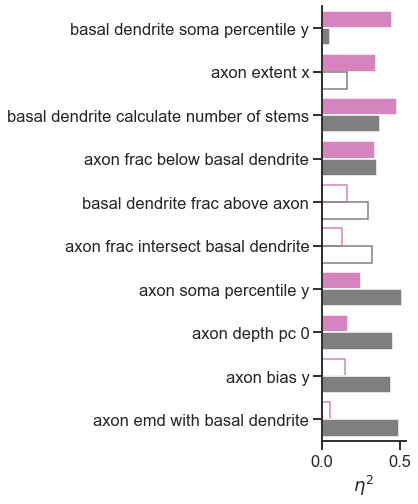

In [225]:
cluster_var = "homology_type"
results_list = [utils.run_cluster_anova(data.query(f"species=='{x}'"), features,
                                       cluster_var=cluster_var)
                for x in group_list]

res = utils.compile_feature_effects_comparison(
    results_list, group_list, effect='rsquared', pval='pval_cluster', rank='max',
    corr_filter=corr_filter, corr_thresh=0.75)

utils.plot_feature_effects_comparison_barplot(
    res, pval='pval_cluster', val='rsquared', 
    ylabels=ylabels, palette=species_palette)

In [227]:
res

KW_H pval_cluster  rsquared  \
                                              human        human     human   
feature                                                                      
basal_dendrite_soma_percentile_y          24.574233     0.000483  0.365665   
axon_extent_x                             22.275079     0.000972  0.326696   
basal_dendrite_calculate_number_of_stems  35.301750     0.000005  0.547487   
axon_frac_above_basal_dendrite            21.199827     0.001220  0.308472   
axon_frac_below_basal_dendrite            18.467792     0.003592  0.262166   
axon_depth_pc_0                           11.622376     0.028035  0.146142   
axon_bias_y                                6.793903     0.129581  0.064303   
axon_soma_percentile_y                    13.404582     0.016042  0.176349   
axon_emd_with_basal_dendrite               3.523525     0.360087  0.008873   
basal_dendrite_frac_above_axon             8.785787     0.071575  0.098064   

                                          epsilon2       KW_H pval_cluster  \
                                             human      mouse        mouse   
feature                                                                      
basal_dendrite_soma_percentile_y          0.396359   2.212088     0.643051   
axon_extent_x                             0.359275   6.244780     0.189436   
basal_dendrite_calculate_number_of_stems  0.569383  14.366152     0.018789   
axon_frac_above_basal_dendrite            0.341933  10.540950     0.041043   
axon_frac_below_basal_dendrite            0.297868  14.981364     0.018693   
axon_depth_pc_0                           0.187458  16.548832     0.011717   
axon_bias_y                               0.109579  14.254121     0.018789   
axon_soma_percentile_y                    0.216203  19.214560     0.006295   
axon_emd_with_basal_dendrite              0.056831  16.444986     0.011717   
basal_dendrite_frac_above_axon            0.141706  23.414927     0.001688   

                                          rsquared  epsilon2       max  \
                                             mouse     mouse             
feature                                                                  
basal_dendrite_soma_percentile_y         -0.022512  0.058213  0.396359   
axon_extent_x                             0.092708  0.164336  0.359275   
basal_dendrite_calculate_number_of_stems  0.324747  0.378057  0.569383   
axon_frac_above_basal_dendrite            0.215456  0.277393  0.341933   
axon_frac_below_basal_dendrite            0.342325  0.394246  0.394246   
axon_depth_pc_0                           0.387109  0.435496  0.435496   
axon_bias_y                               0.321546  0.375108  0.375108   
axon_soma_percentile_y                    0.463273  0.505646  0.505646   
axon_emd_with_basal_dendrite              0.384142  0.432763  0.432763   
basal_dendrite_frac_above_axon            0.583284  0.616182  0.616182   

                                              diff  
                                                    
feature                                             
basal_dendrite_soma_percentile_y          0.338146  
axon_extent_x                             0.194939  
basal_dendrite_calculate_number_of_stems  0.191326  
axon_frac_above_basal_dendrite            0.064539  
axon_frac_below_basal_dendrite           -0.096379  
axon_depth_pc_0                          -0.248038  
axon_bias_y                              -0.265529  
axon_soma_percentile_y                   -0.289443  
axon_emd_with_basal_dendrite             -0.375932  
basal_dendrite_frac_above_axon           -0.474476

basal_dendrite_soma_percentile_y


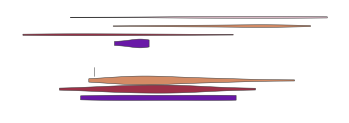

axon_extent_x


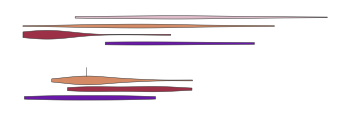

basal_dendrite_calculate_number_of_stems


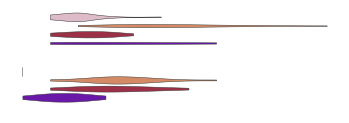

axon_emd_with_basal_dendrite


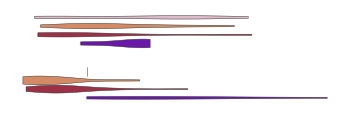

In [230]:
feats = ['basal_dendrite_soma_percentile_y', 
         'axon_extent_x',
         'basal_dendrite_calculate_number_of_stems', 
        'axon_emd_with_basal_dendrite']
for feat in feats:
    print(feat)
    fig, ax = plt.subplots(figsize=(6,2))
    sns.violinplot(data=data, x=feat, y='species', hue='homology_type', 
                   cut=0, legend=False, palette=palette_subclass, scale='area', scale_hue=True,
                  inner=None, linewidth=0.5, dodge=True, ax=ax,)
    plt.legend().remove()
    ax.axis('off')
    plt.show()

## Boxplots from ANOVA feats

(0.0, 25.0)

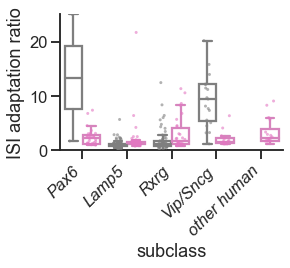

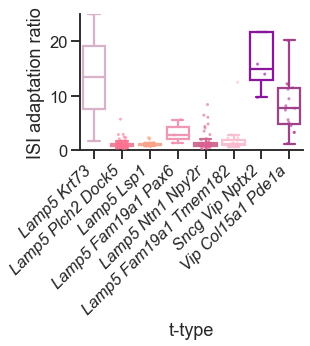

In [57]:
y = 'isi_adapt_ratio'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
plt.ylim(0,25)
plt.ylabel('ISI adaptation ratio')
plt.xlabel('subclass')
plot.box_strip(data=mouse_l1, x=cluster, y=y, hue=cluster, palette=palette_mouse, dodge=False)
plt.ylabel('ISI adaptation ratio')
plt.ylim(0,25)

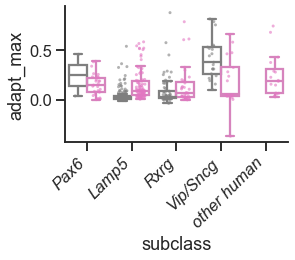

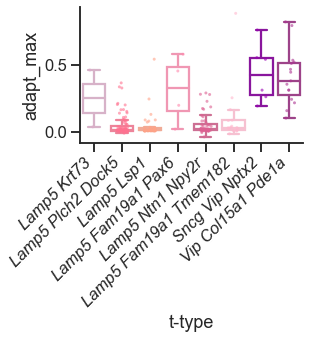

In [56]:
y = 'adapt_max'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
# plt.ylim(0,25)
# plt.ylabel('ISI adaptation ratio')
plt.xlabel('subclass')
plot.box_strip(data=mouse_l1, x=cluster, y=y, hue=cluster, palette=palette_mouse, dodge=False)
# plt.ylabel('ISI adaptation ratio')
# plt.ylim(0,25)

Text(0.5, 0, 'subclass')

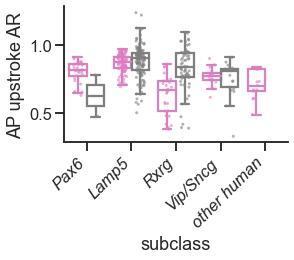

In [95]:
y = 'upstroke_adapt_ratio'
ylabel = 'AP upstroke AR'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
plt.ylabel(ylabel)
plt.xlabel('subclass')

Text(0, 0.5, 'AP upstroke AR')

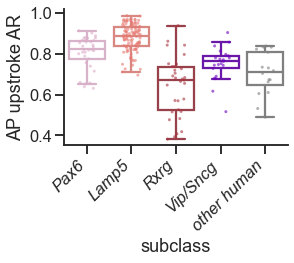

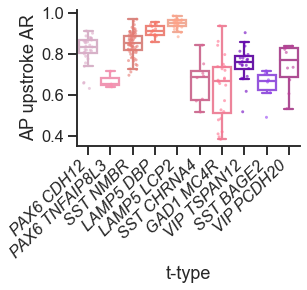

In [97]:
plot.box_strip(data=human_df, x='homology_type', y=y, palette=palette_subclass,legend=False)
plt.ylabel(ylabel)
plt.xlabel('subclass')
plot.box_strip(data=human_df, x=cluster, y=y, palette=palette_human)
plt.ylabel(ylabel)

Text(0.5, 0, 'subclass')

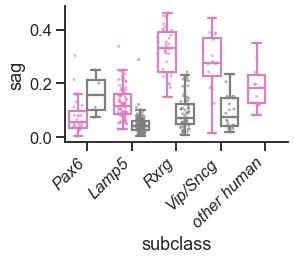

In [99]:
y = 'sag'
ylabel = y
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
plt.ylabel(ylabel)
plt.xlabel('subclass')

Text(0, 0.5, 'sag')

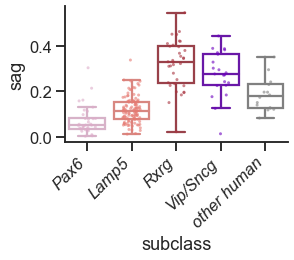

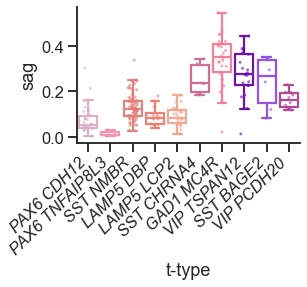

In [100]:
plot.box_strip(data=human_aibs, x='homology_type', y=y, palette=palette_subclass,legend=False)
plt.ylabel(ylabel)
plt.xlabel('subclass')
plot.box_strip(data=human_aibs, x=cluster, y=y, palette=palette_human)
plt.ylabel(ylabel)

In [147]:
reload(ps)

<module 'ateam.analysis.plot.sweeps' from '/home/tom.chartrand/work/ateam-tools/ateam/analysis/plot/sweeps.py'>

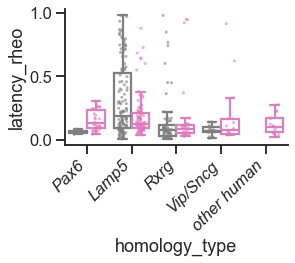

In [86]:
# could support idea of more human diversity in Pax6/Rxrg, more mouse in Sncg/Lamp5
y = 'latency_rheo'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)

### Morpho

Text(0.5, 0, 'human t-type')

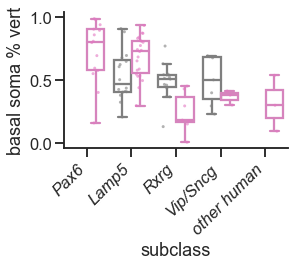

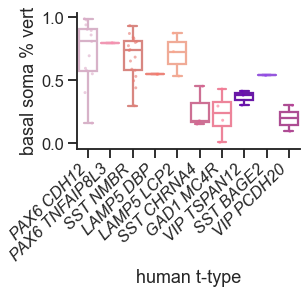

In [67]:
y = 'basal_dendrite_soma_percentile_y'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
plt.ylabel('basal soma % vert')
plt.xlabel('subclass')
plot.box_strip(data=human_l1, x=cluster, y=y, hue=cluster, palette=palette_human, dodge=False)
plt.ylabel('basal soma % vert')
plt.xlabel('human t-type')

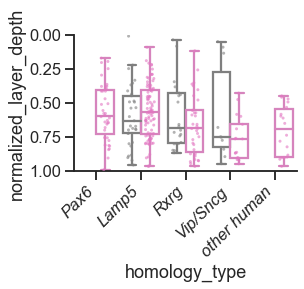

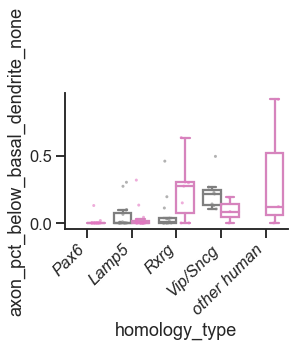

In [80]:
y = 'normalized_layer_depth'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
plt.ylim([1,0])

y = 'axon_pct_below_basal_dendrite_none'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)

Text(0.5, 0, 'mouse t-type')

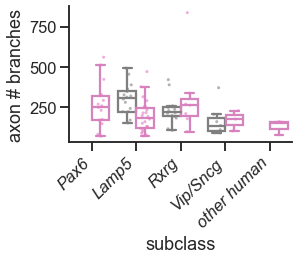

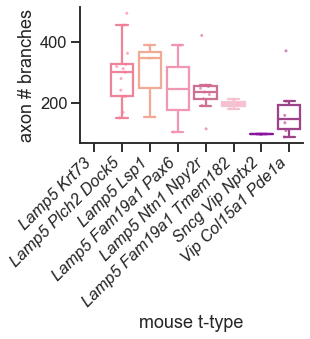

In [65]:
y = 'axon_num_branches_none'
name = 'axon # branches'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
plt.ylabel(name)
plt.xlabel('subclass')
plot.box_strip(data=mouse_l1, x=cluster, y=y, hue=cluster, palette=palette_mouse, dodge=False)
plt.ylabel(name)
plt.xlabel('mouse t-type')

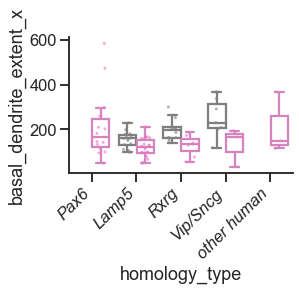

In [81]:
y = 'basal_dendrite_extent_x'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)

## Example traces

In [376]:
import matplotlib
def plot_type(ttype, feature, plot_fcn, species, ttype_color=True, ax=None, stimulus="Long Square"):
    cells = combined.loc[combined[cluster]==ttype] 
    cell = (cells[feature] - cells[feature].median()).abs().argmin()
    dataset, sweeps = ps.get_dataset_sweeps(cell, lims_sweep_info=True, qc_sweeps=True, sweeps_query=None, stimulus=stimulus)
    plt.sca(ax)
    if not ttype_color:
        color = species_palette[species]
    else:
        color = palette_subclass[combined.loc[cell, 'homology_type']]
        if combined.loc[cell, 'species']=='mouse':
            color = np.array(matplotlib.colors.to_rgb(color))
            color = (color + 2*color.mean()*np.ones(3))/2.5
    plot_fcn(dataset, sweeps, color=color)
    
def plot_5spike(dataset, sweeps, color):
    sweepset = dataset.sweep_set(sweeps.query('num_spikes >= 5').sort_values('num_spikes')["sweep_number"].values[0])
    ps.plot_sweeps_thumb(sweepset, color=color)

def plot_comparison(types_dict, feature, plot_fcn, n_types=2, stimulus="Long Square"):
    fig, axes = plt.subplots(2,n_types, figsize=(4*n_types,6), squeeze=False)
    for i, (species, ttypes) in enumerate(types_dict.items()):
        for j, ttype in enumerate(ttypes):
            plot_type(ttype, feature, plot_fcn, species=species, ttype_color=n_types>1, ax=axes[i,j], stimulus=stimulus)
            if j==0:
                plt.axis('on')
                plt.box(False)
                axes[i,j].set_ylabel(species)
                axes[i,j].set_yticks([])
                axes[i,j].get_xaxis().set_visible(False)
            if i==0 and n_types>1:
                axes[i,j].set_title(homology_mapping_human[ttype] if species=='human' else homology_mapping_mouse[ttype])
                

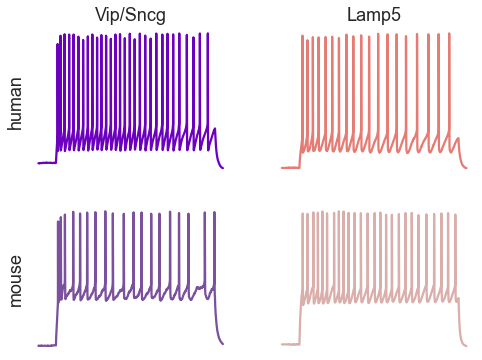

In [122]:
types_dict = {
    'human':[
    'VIP TSPAN12',
    'SST NMBR'
    ],
    'mouse':[
    'Sncg Vip Nptx2',
    'Lamp5 Plch2 Dock5',
    ],
}
feature, plot_fcn = 'isi_adapt_ratio', plot_5spike
plot_comparison(types_dict, feature, plot_fcn)

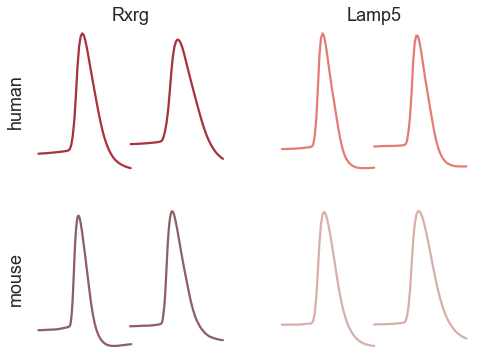

In [150]:
def plot_spike_adapt(dataset, sweeps, color):
    sweep = dataset.sweep(sweeps.query('num_spikes >= 5').sort_values('num_spikes')["sweep_number"].values[0])
    ps.plot_sweep_spikes(sweep, nspikes=[0,3], color=color)
#     plt.xlim(t0-1e-3, t0+0.02)
    
types_dict = {
    'human':[
    'SST CHRNA4',
    'SST NMBR'
    ],
    'mouse':[
    'Lamp5 Fam19a1 Tmem182',
    'Lamp5 Plch2 Dock5',
    ],
}
feature, plot_fcn = 'upstroke_adapt_ratio', plot_spike_adapt
plot_comparison(types_dict, feature, plot_fcn)

# Uniform diffs

In [381]:
reload(ps)

<module 'patchseq_utils.plot.sweeps' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/plot/sweeps.py'>

In [385]:
from functools import partial

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/hdmf/spec/namespace.py:504: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/hdmf/spec/namespace.py:504: UserWarning: Ignoring cached namespace 'core' version 2.2.4 because version 2.2.5 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/hdmf/spec/namespace.py:504: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/local1/storage/envs/ipfx3/lib/python3.7/site-packages/hdmf/spec/namespace.py:504: UserWarning: Ignoring cached namespace 'core' version 2.2.4 because version 2.2.5 is already loaded.
  % (ns['name

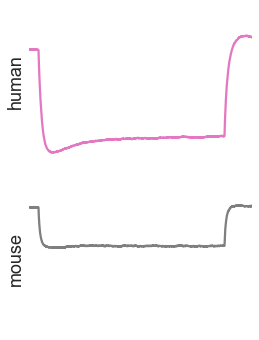

In [386]:
types_dict = {
    'human':[
    'LAMP5 NMBR'
    ],
    'mouse':[
    'Lamp5 Plch2 Dock5',
    ],
}
def plot_hyperpol(dataset, sweeps, color):
    sweeps = sweeps.set_index('sweep_number')
    sweep = (sweeps['stimulus_amplitude'] - -40).abs().argsort().values[0]
    ps.plot_sweeps_thumb(dataset.sweep_set([sweep]), color=color, dy=30)
    
# feature, plot_fcn = 'input_resistance', plot_hyperpol
feature, plot_fcn = 'sag', partial(ps.plot_sag, n_max=1, dy=40)
plot_comparison(types_dict, feature, plot_fcn, n_types=1)

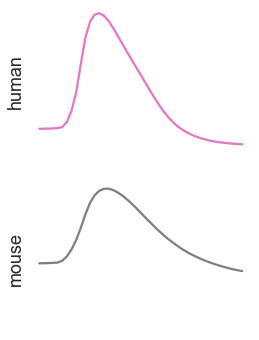

In [179]:
def plot_first_spike(dataset, sweeps, color):
    sweep = sweeps["sweep_number"].values[0]
    ps.plot_sweep_spikes(dataset.sweep(sweep), color=color, dy=100, pre=0.2, scalebar=False)
    
feature, plot_fcn = 'peak_deltav_ramp', plot_first_spike
plot_comparison(types_dict, feature, plot_fcn, n_types=1, stimulus="Ramp")

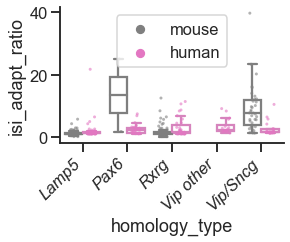

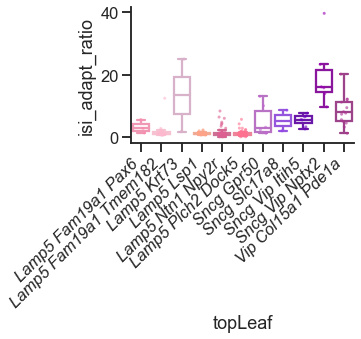

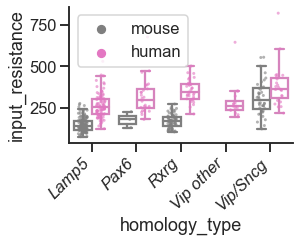

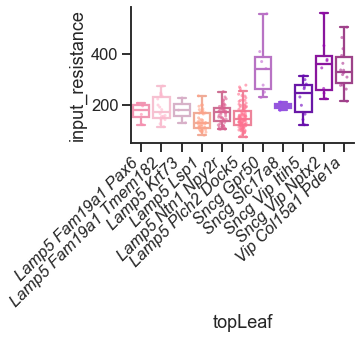

In [83]:
combined.loc[lambda df: df['input_resistance'] > 1000, 'input_resistance'] = np.nan
for y in ['isi_adapt_ratio', 'input_resistance']:
    plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=True)
    plot.box_strip(data=mouse_l1, x='topLeaf', y=y, hue='topLeaf', palette=palette_mouse, dodge=False)

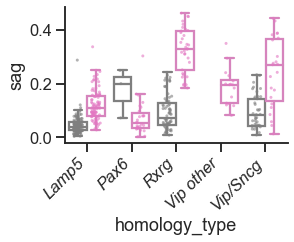

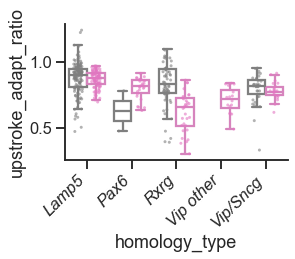

In [85]:
for y in ['sag', 'upstroke_adapt_ratio']:
    plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
#     plot.box_strip(data=human_aibs, x='topLeaf', y=y, hue='topLeaf', palette=palette_human, dodge=False)

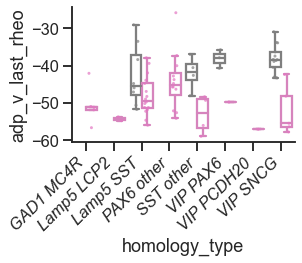

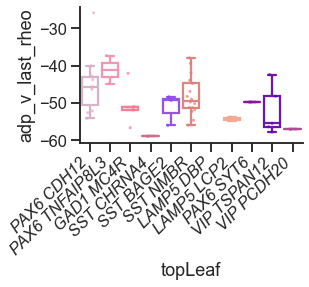

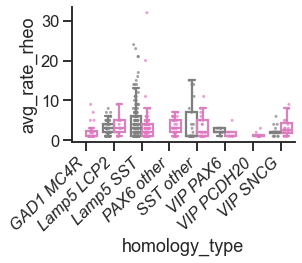

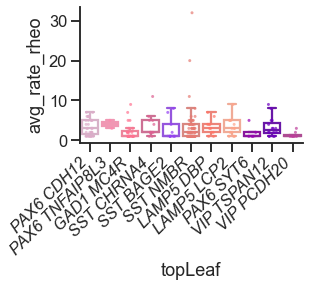

In [717]:
for y in ['adp_v_last_rheo', 'avg_rate_rheo']:
    box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=False)
    box_strip(data=human_aibs, x='topLeaf', y=y, hue='topLeaf', palette=palette_human, dodge=False)

In [ ]:
y = 'isi_adapt_ratio'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=True)

### sag related props

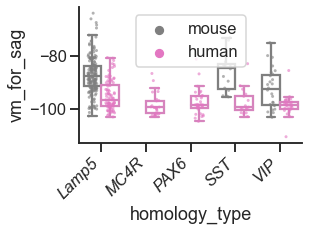

In [366]:
y = 'vm_for_sag'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=True)

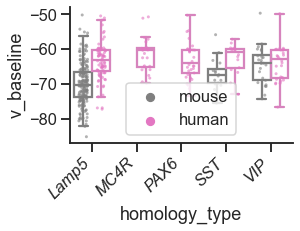

In [371]:
y = 'v_baseline'
plot.box_strip(data=combined, x='homology_type', y=y, hue='species', palette=species_palette, dodge=True, legend=True)

# K channel recordings

In [291]:
channels_df = pd.read_csv("/home/tom.chartrand/projects/human_l1/L1_homologous_channel_cells.csv", index_col=1)
channels_df.head()

Unnamed: 0  total_v_half  total_slope  \
cell_name                                                                      
H19.03.305.11.10.01.06                         11     -6.370183    13.678684   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02          52           NaN          NaN   
H19.03.319.11.04.01.01                         54    -10.453496     9.909890   
H19.03.323.11.04.01.05                         77      1.428486    14.016928   
H19.06.351.11.16.02.03                        125     15.516560    10.017801   

                                       slow_v_half  slow_slope  fast_v_half  \
cell_name                                                                     
H19.03.305.11.10.01.06                         NaN         NaN     7.456774   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02          NaN         NaN          NaN   
H19.03.319.11.04.01.01                  -18.446655   11.155533     2.644184   
H19.03.323.11.04.01.05                         NaN         NaN   -40.481452   
H19.06.351.11.16.02.03                    9.238993   11.119369     4.466508   

                                       fast_slope  sus_v_half  sus_slope  \
cell_name                                                                  
H19.03.305.11.10.01.06                  17.809239         NaN        NaN   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02         NaN         NaN        NaN   
H19.03.319.11.04.01.01                  15.032388   33.617053  13.161699   
H19.03.323.11.04.01.05                  44.257497         NaN        NaN   
H19.06.351.11.16.02.03                  59.810200   -3.398264   2.273635   

                                       total_peak_current  \
cell_name                                                   
H19.03.305.11.10.01.06                         864.770813   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02                 NaN   
H19.03.319.11.04.01.01                        1041.547607   
H19.03.323.11.04.01.05                         511.423248   
H19.06.351.11.16.02.03                        1598.805298   

                                       total_current_density  \
cell_name                                                      
H19.03.305.11.10.01.06                              6.744556   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02                    NaN   
H19.03.319.11.04.01.01                              5.805377   
H19.03.323.11.04.01.05                              2.604785   
H19.06.351.11.16.02.03                              7.144319   

                                       total_conductance  \
cell_name                                                  
H19.03.305.11.10.01.06                          5.086887   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02                NaN   
H19.03.319.11.04.01.01                          6.126751   
H19.03.323.11.04.01.05                          3.008372   
H19.06.351.11.16.02.03                          9.404737   

                                       total_conductance_density  \
cell_name                                                          
H19.03.305.11.10.01.06                                  0.039674   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02                        NaN   
H19.03.319.11.04.01.01                                  0.034149   
H19.03.323.11.04.01.05                                  0.015322   
H19.06.351.11.16.02.03                                  0.042025   

                                       slow_peak_current  \
cell_name                                                  
H19.03.305.11.10.01.06                               NaN   
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02                NaN   
H19.03.319.11.04.01.01                        608.312988   
H19.03.323.11.04.01.05                               NaN   
H19.06.351.11.16.02.03                       1400.537842   

                                       slow_current_density  slow_conductance  \
cell_name                                                                       
H19.03.305.11.10.01.06           

In [305]:
channels = combined_morph.join(channels_df, on='cell_name', rsuffix='_r', how='inner')
channels = channels.query('homology_type!="L1 VIP"')
channels.homology_type.cat.remove_unused_categories(inplace=True)

In [306]:
channels.groupby(['homology_type','species']).slow_conductance_density.apply(lambda x: x.notna().sum())

homology_type  species
PAX6           human      1.0
               mouse      NaN
LAMP5          human      5.0
               mouse      2.0
MC4R           human      2.0
               mouse      NaN
Name: slow_conductance_density, dtype: float64

In [307]:
channels.groupby(['homology_type','species']).fast_conductance_density.apply(lambda x: x.notna().sum())

homology_type  species
PAX6           human      2.0
               mouse      NaN
LAMP5          human      7.0
               mouse      4.0
MC4R           human      4.0
               mouse      NaN
Name: fast_conductance_density, dtype: float64

In [308]:
channels.groupby(['homology_type','species']).total_conductance_density.apply(lambda x: x.notna().sum())

homology_type  species
PAX6           human      4.0
               mouse      NaN
LAMP5          human      8.0
               mouse      5.0
MC4R           human      5.0
               mouse      NaN
Name: total_conductance_density, dtype: float64

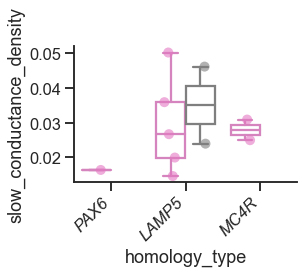

In [309]:
y = "slow_conductance_density"
plot.box_strip(data=channels, x='homology_type', y=y, hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False, size=10)

In [323]:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

Text(0.5, 1.0, 'fast K+ cond. density ($nS/\\mu m^2$)')

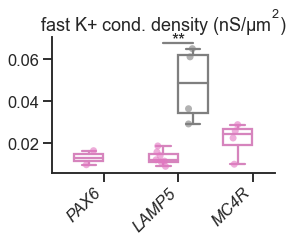

In [388]:
y = "fast_conductance_density"
plot.plot_nested_comparisons(data=channels, x='homology_type', y=y, compare='species', 
                   palette=species_palette, size=7)
plt.xlabel(None)
plt.ylabel(None)
plt.title("fast K+ cond. density ($nS/\mu m^2$)")

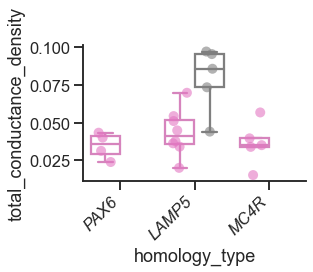

In [311]:
y = "total_conductance_density"
plot.plot_nested_comparisons(data=channels, x='homology_type', y=y, hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False, size=10)